
I rewrote the codes posted by MunoNeutrino for the competition-“Web Traffic Time Series Forecasting”. I made the following changes:

1. Relabel the x-axis tick marks using real dates instead of days. 
2. Perform the Dickey-Fuller test to determine the stationary of the data
3. As to stationary data, use ARMA model to forecast
4. As to non-stationary data, take the first difference to transform them to stationary, fit ARIMA model
5. Fit a few models, then use Information Criterion to choose best model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
%matplotlib inline

In [2]:
train = pd.read_csv('/Users/Wanyi/Documents/zhuan/practice/Kaggle/Time series/Web Traffic Time Series Forecasting/data/train_1.csv').fillna(0)

In [3]:
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09     ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0     ...            32.0        63.0        15.0        26.0   
1        10.0     ...            17.0        42.0        28.0        15.0   
2         4.0     ...             3.0         1.0         1.0         7.0   
3        11.0     ...            32.0        10.0        26.0        27.0   
4         0.0     ...            48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [5]:

for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col],downcast='integer')
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider          18          11   
1             2PM_zh.wikipedia.org_all-access_spider          11          14   
2              3C_zh.wikipedia.org_all-access_spider           1           0   
3         4minute_zh.wikipedia.org_all-access_spider          35          13   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...           0           0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0           5          13          14           9           9          22   
1          15          18          11          13          22          11   
2           1           1           0           4           0           3   
3          10          94           4          26          14           9   
4           0           0           0           0           0           0   

   2015-07-09     ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0          26     ...              32          63          15          26   
1          10     ...              17          42          28          15   
2           4     ...               3           1           1           7   
3          11     ...              32          10          26          27   
4           0     ...              48           9          25          13   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0          14          20          22          19          18          20  
1           9          30          52          45          26          20  
2           4           4           6           3           4          17  
3          16          11          17          19          10          11  
4           3          11          27          13          36          10  

[5 rows x 551 columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: int32(550), object(1)
memory usage: 305.5+ MB


In [7]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)
from collections import Counter
print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [8]:
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider          18          11   
1             2PM_zh.wikipedia.org_all-access_spider          11          14   
2              3C_zh.wikipedia.org_all-access_spider           1           0   
3         4minute_zh.wikipedia.org_all-access_spider          35          13   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...           0           0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0           5          13          14           9           9          22   
1          15          18          11          13          22          11   
2           1           1           0           4           0           3   
3          10          94           4          26          14           9   
4           0           0           0           0           0           0   

   2015-07-09  ...   2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
0          26  ...           63          15          26          14   
1          10  ...           42          28          15           9   
2           4  ...            1           1           7           4   
3          11  ...           10          26          27          16   
4           0  ...            9          25          13           3   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  lang  
0          20          22          19          18          20    zh  
1          30          52          45          26          20    zh  
2           4           6           3           4          17    zh  
3          11          17          19          10          11    zh  
4          11          27          13          36          10    zh  

[5 rows x 552 columns]

In [9]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

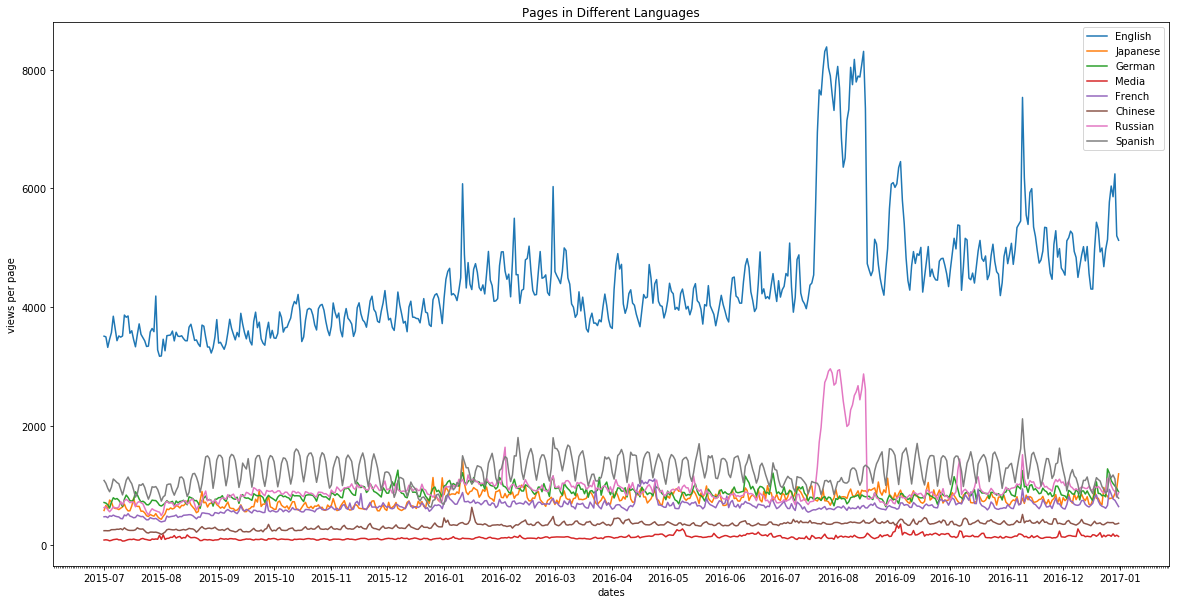

In [10]:
from datetime import datetime
import matplotlib.dates as mdates

months = mdates.MonthLocator()
days = mdates.DayLocator()
ymFmt = mdates.DateFormatter('%Y-%m')


dates = list(train.columns[1:-1])
dates = [datetime.strptime(x, '%Y-%m-%d') for x in dates]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_ylabel('views per page')
ax.set_xlabel('dates')
ax.set_title('Pages in Different Languages')
labels = {'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'}
#tick_spacing = 100

for key in sums:
    ax.plot(dates, sums[key], label=labels[key])
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(ymFmt)
    ax.xaxis.set_minor_locator(days)
    
    #ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    #ax.set_xticklabels(dates(np.arange(lang_sets['en'].shape[1]-1, step=50))
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.legend()
plt.show()

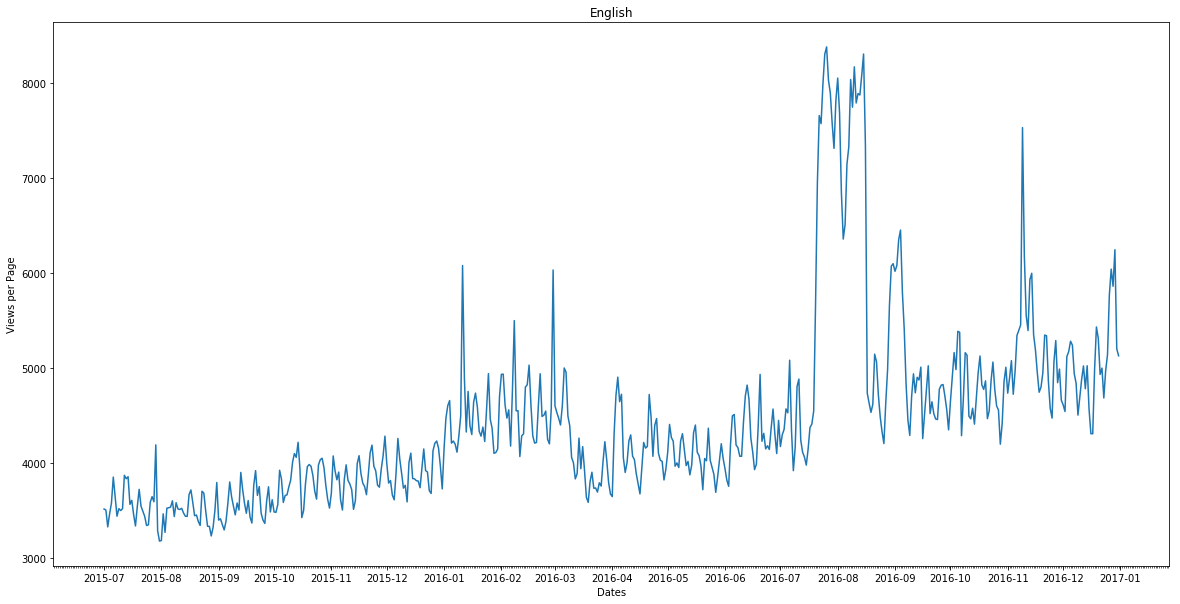

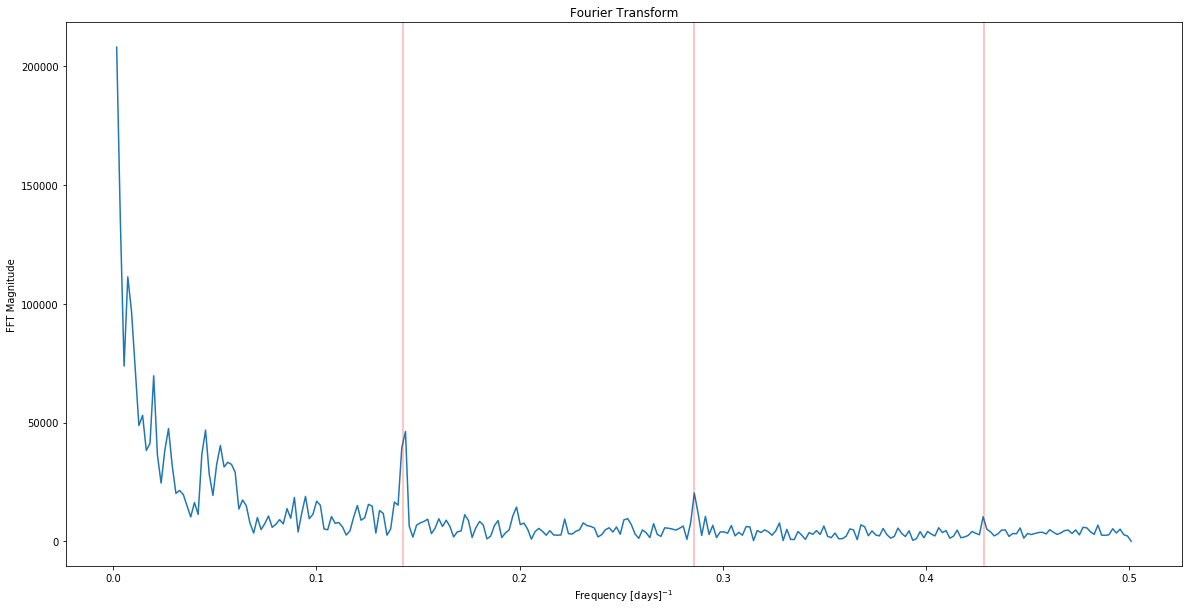

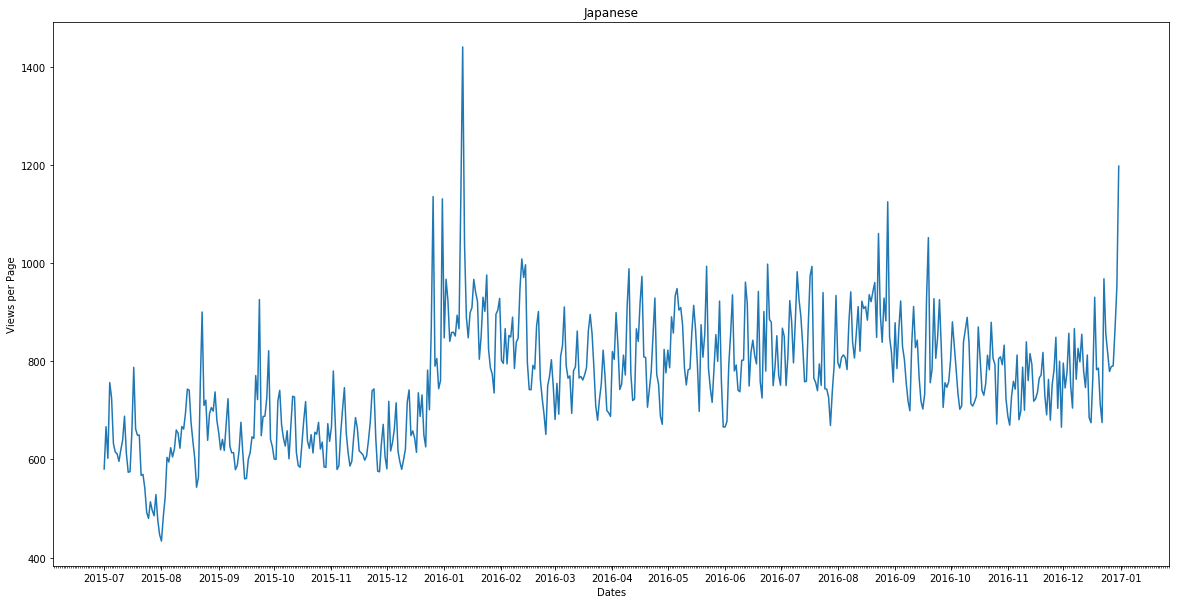

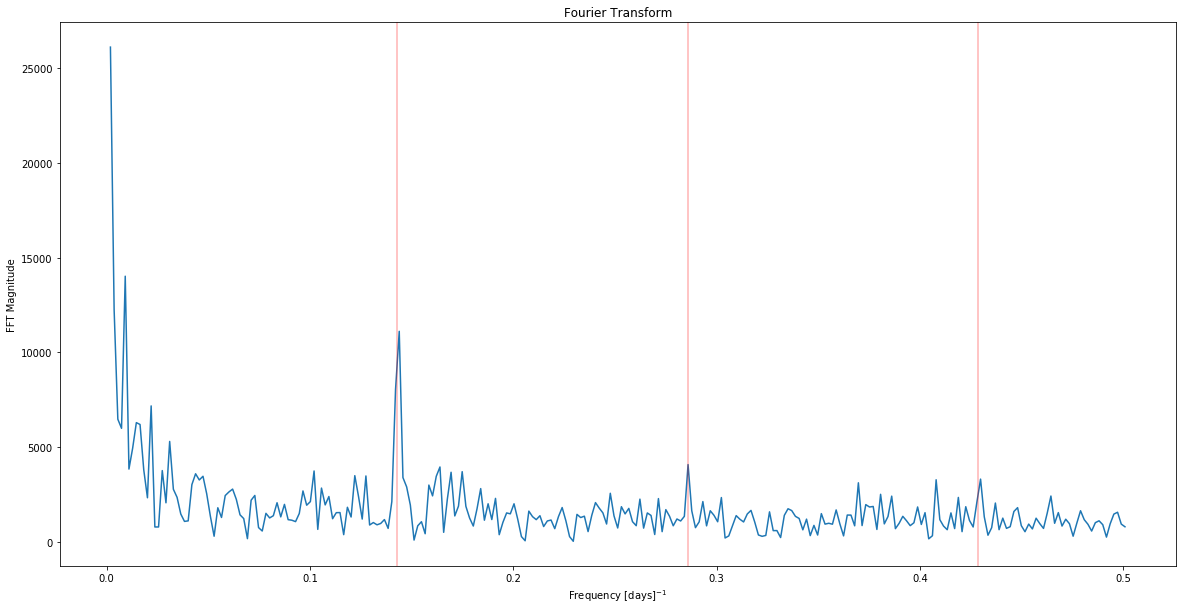

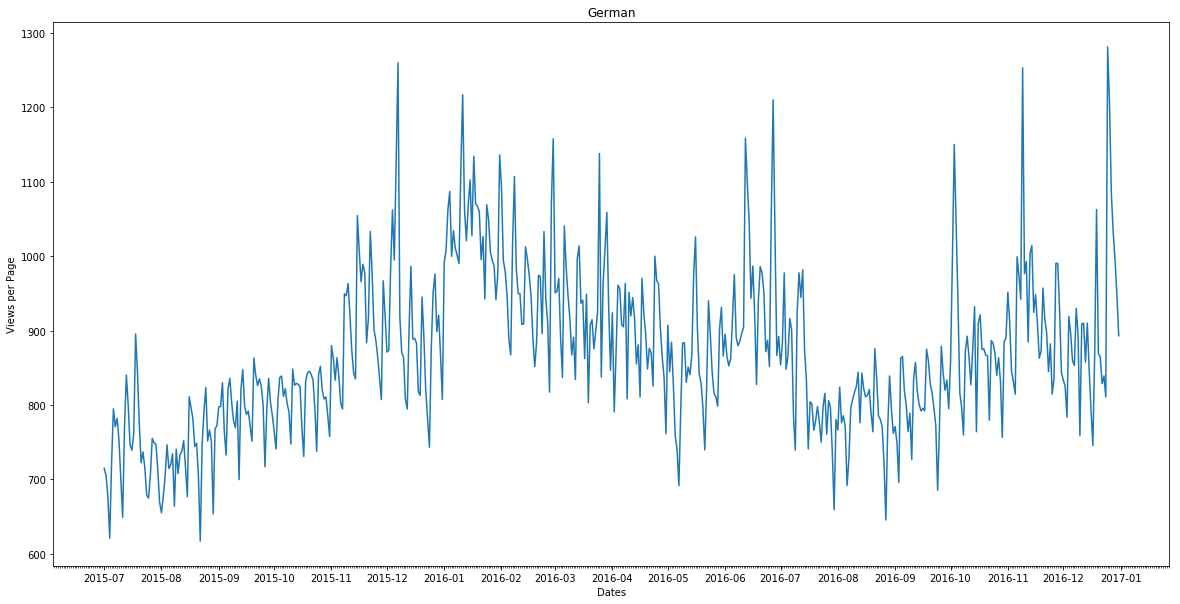

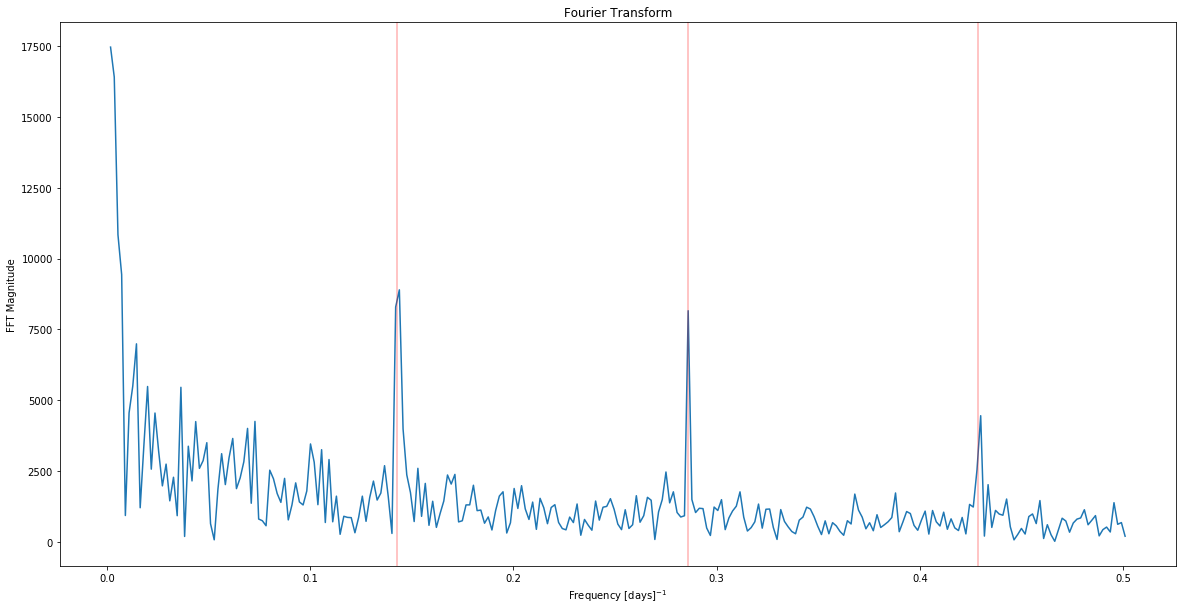

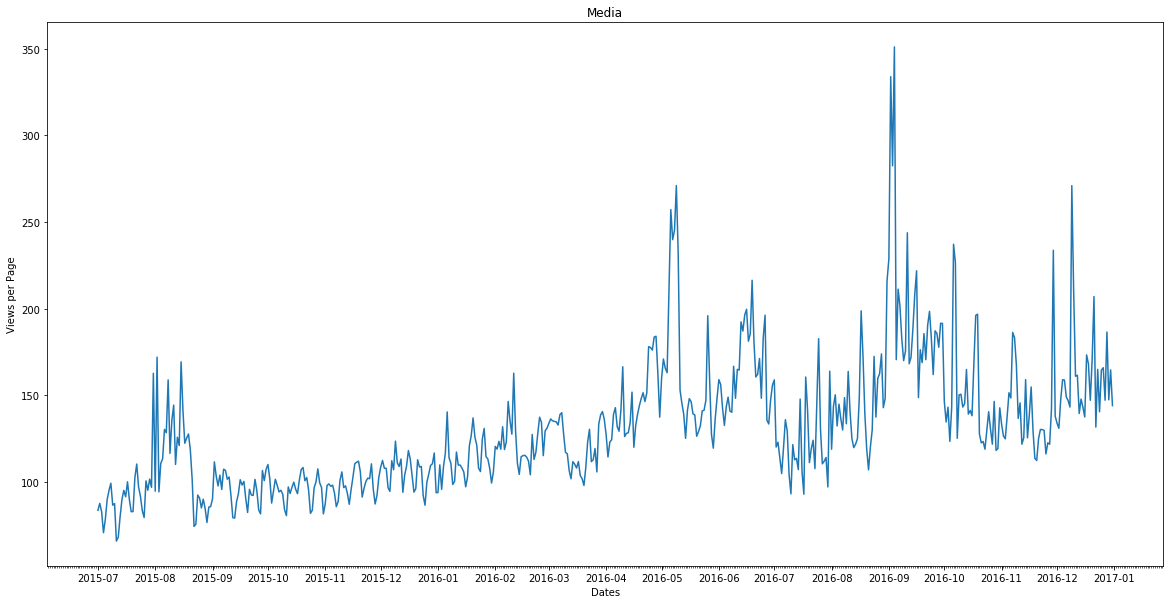

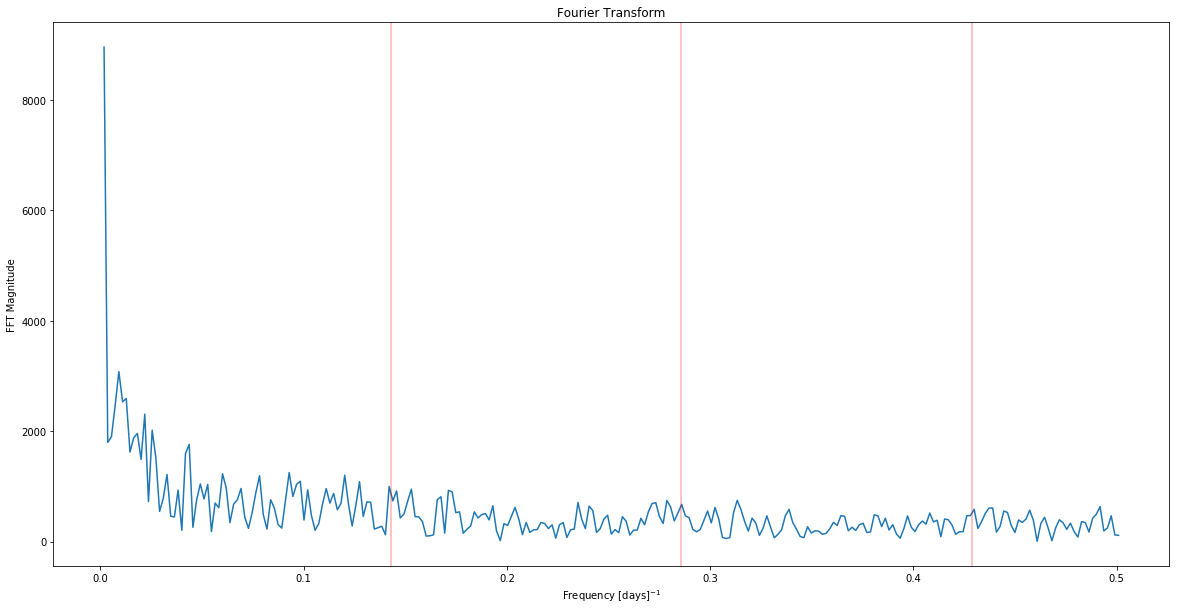

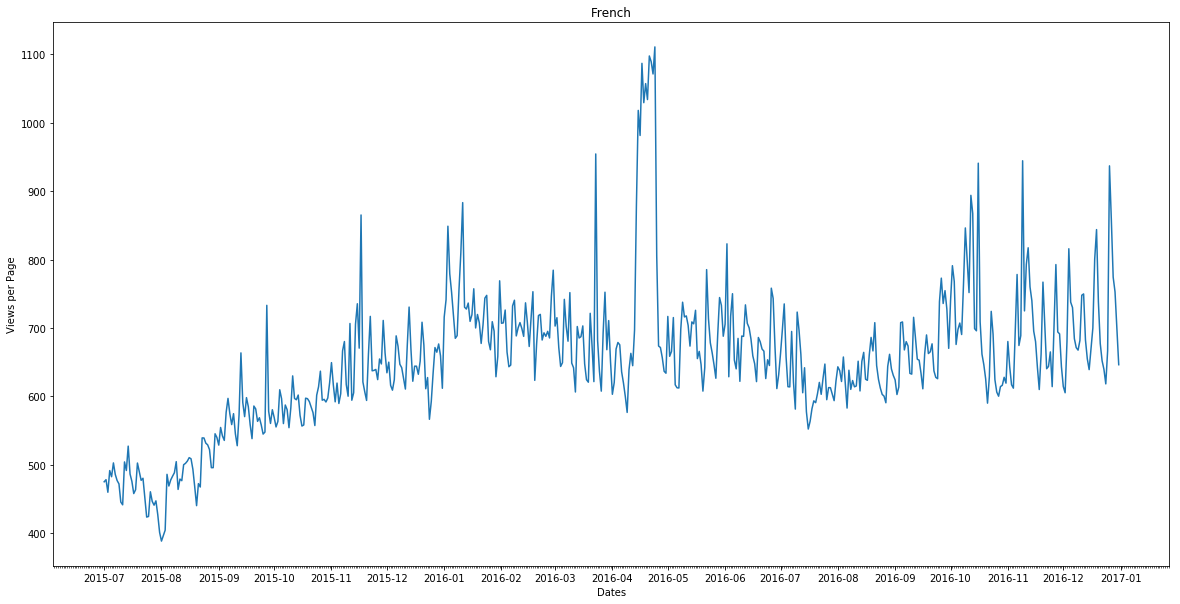

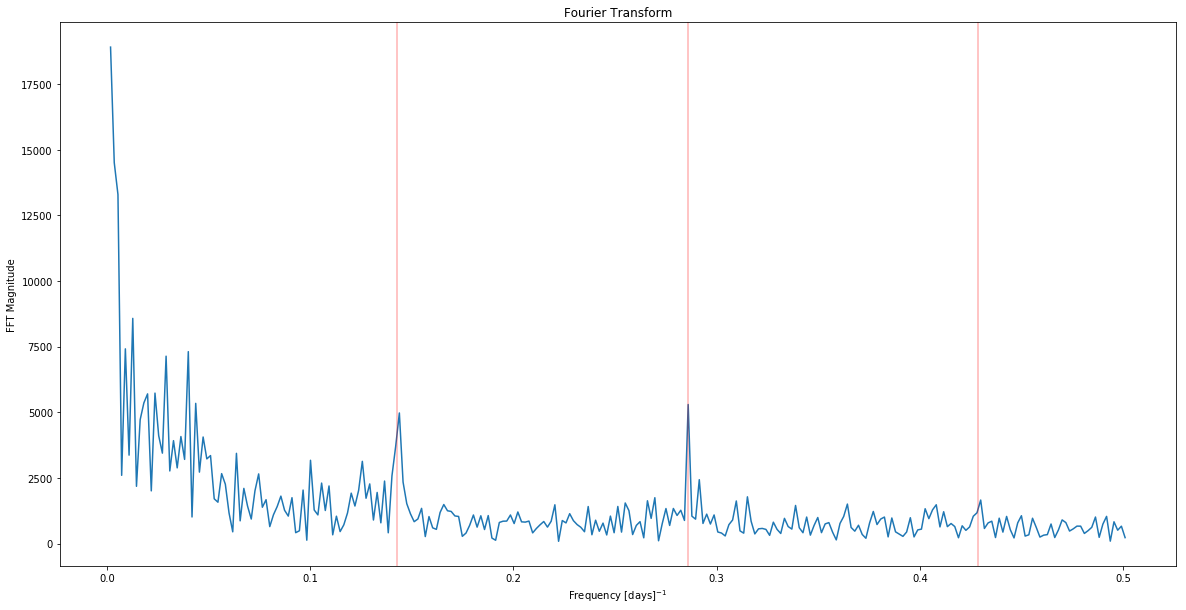

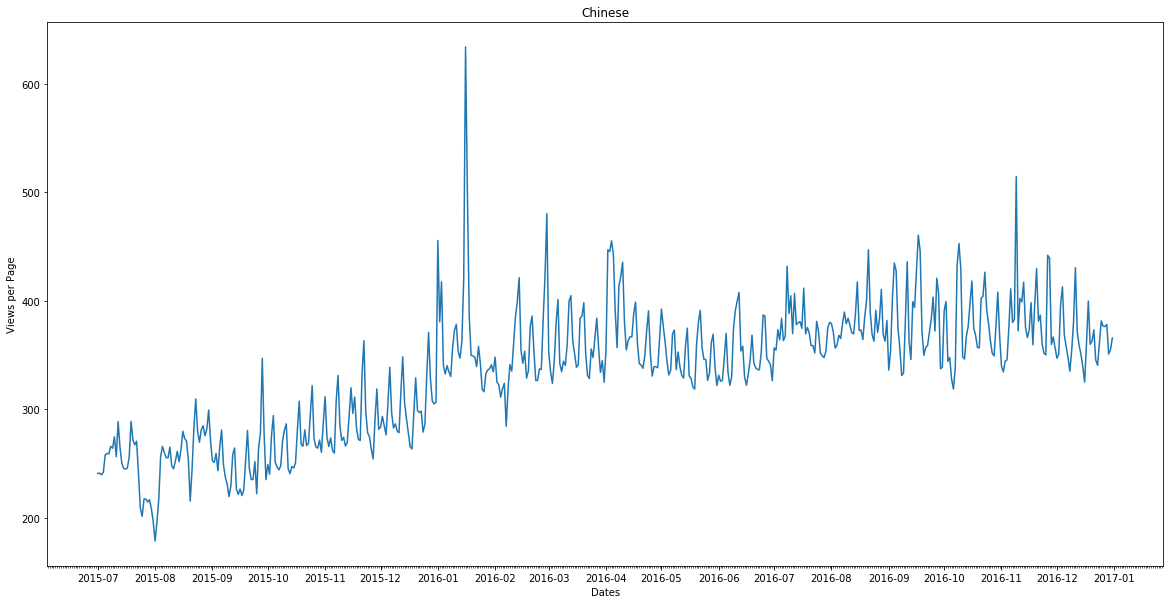

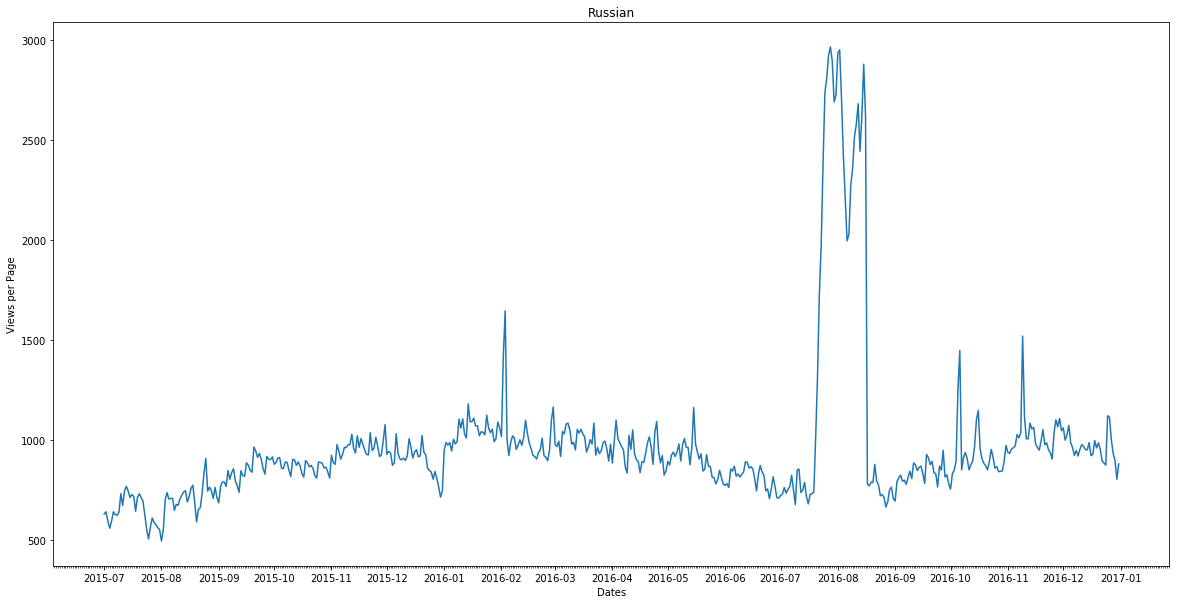

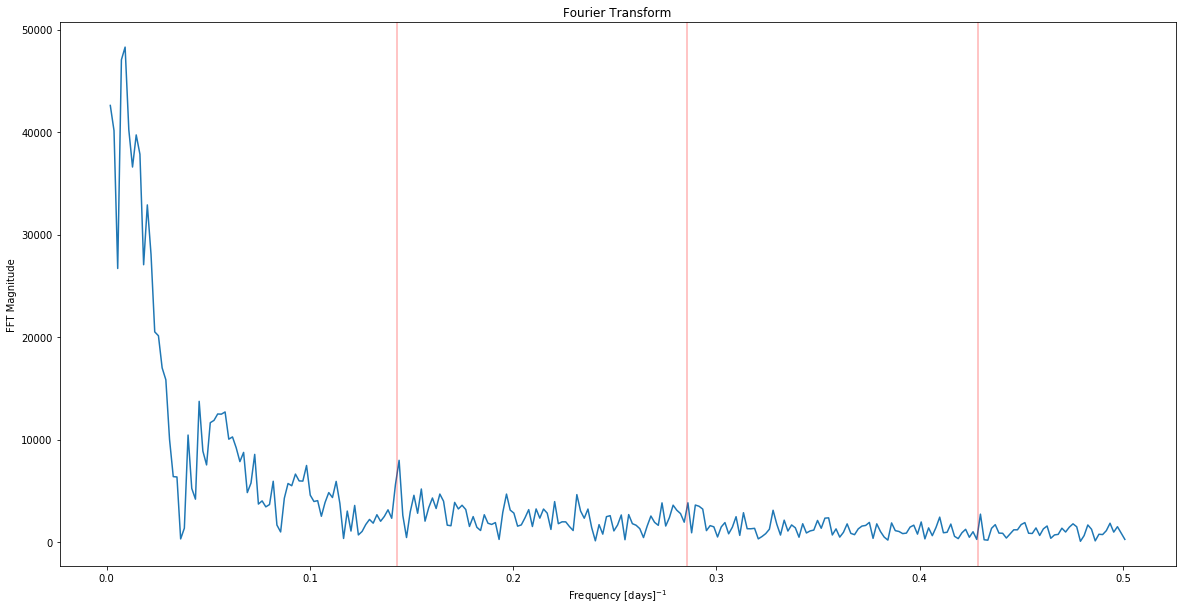

In [11]:
from scipy.fftpack import fft

days = [r for r in range(sums['en'].shape[0])]

def plot_each_lang(key):
    
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    ymFmt = mdates.DateFormatter('%Y-%m')
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
                                  
    ax.plot(dates,sums[key],label = labels[key])
    ax.set_ylabel('Views per Page')
    ax.set_xlabel('Dates')
    ax.set_title(labels[key])
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(ymFmt)
    ax.xaxis.set_minor_locator(days)
    
    
def plot_with_fft(key): 
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    ax.set_ylabel('FFT Magnitude')
    ax.set_xlabel(r"Frequency [days]$^{-1}$")
    ax.set_title('Fourier Transform')
    ax.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    ax.axvline(x=1./7,color='red',alpha=0.3)
    ax.axvline(x=2./7,color='red',alpha=0.3)
    ax.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in sums:
    plot_each_lang(key)
    plot_with_fft(key)
   


In [12]:
def plot_entry(key, idx):
    
    
    data = lang_sets[key].iloc[idx, 1:]
    
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    ymFmt = mdates.DateFormatter('%Y-%m')
    
    fig, ax = plt.subplots(1, 1,  figsize=[20, 10])
    ax.plot(dates, data)
    
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(ymFmt)
    ax.xaxis.set_minor_locator(days)
    
    ax.set_xlabel('Dates')
    ax.set_ylabel('Views')
    ax.set_title(lang_sets[key].iloc[idx, 0])
    
    
    plt.show()

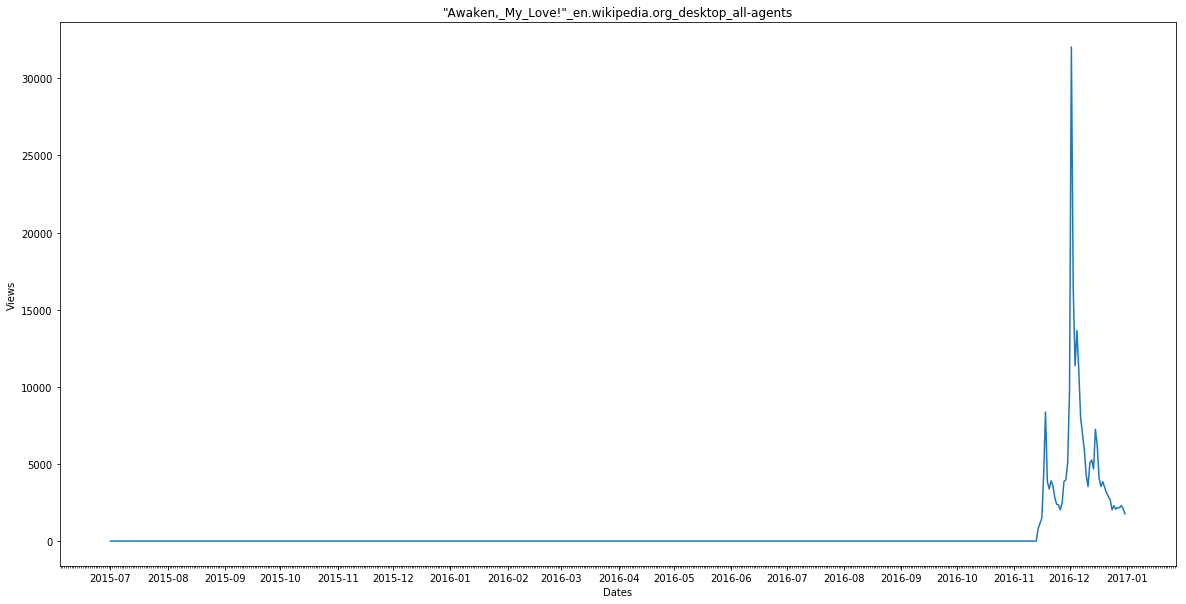

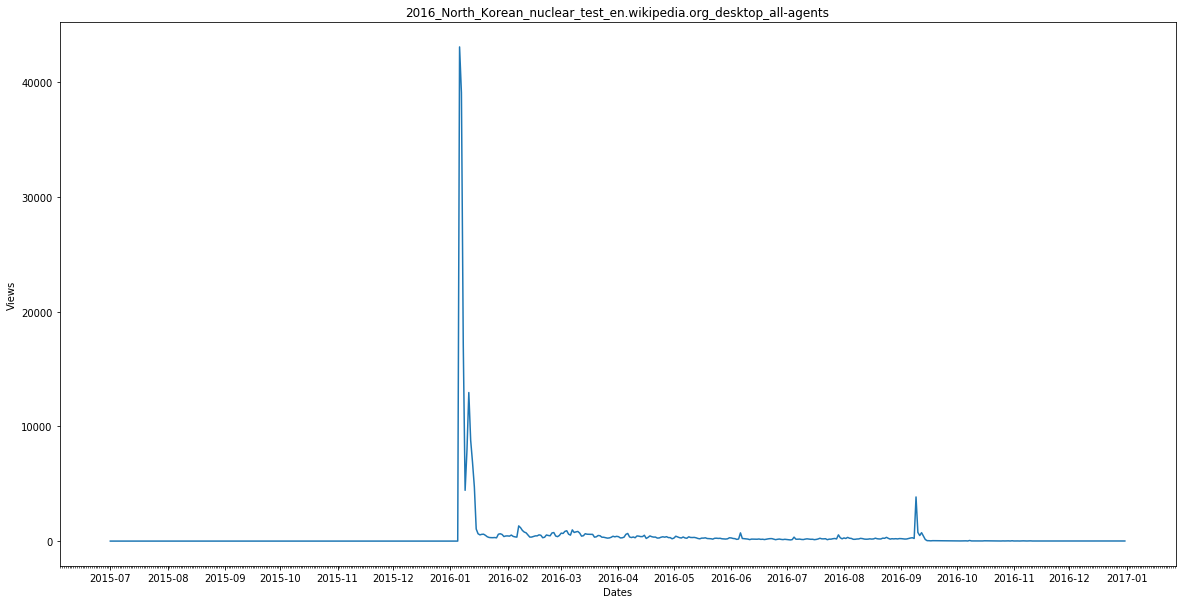

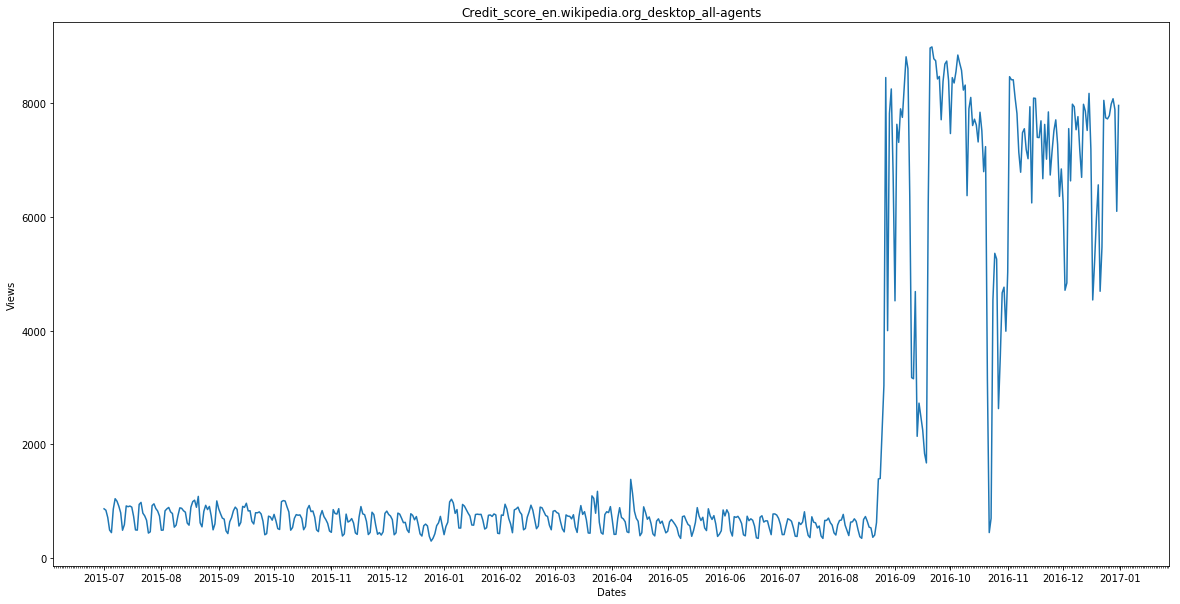

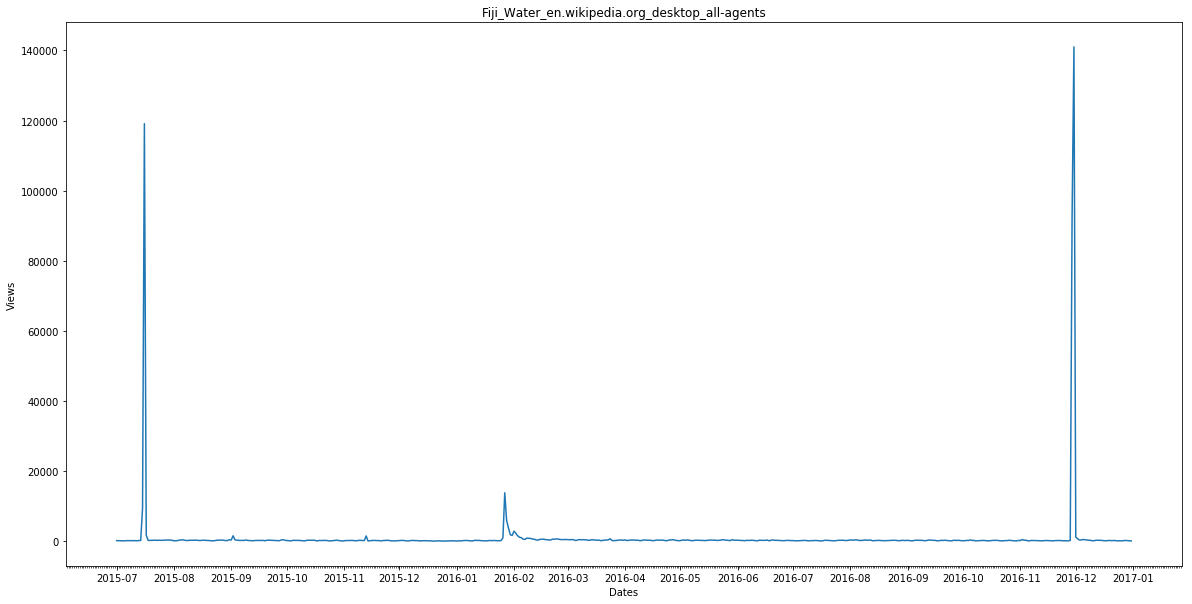

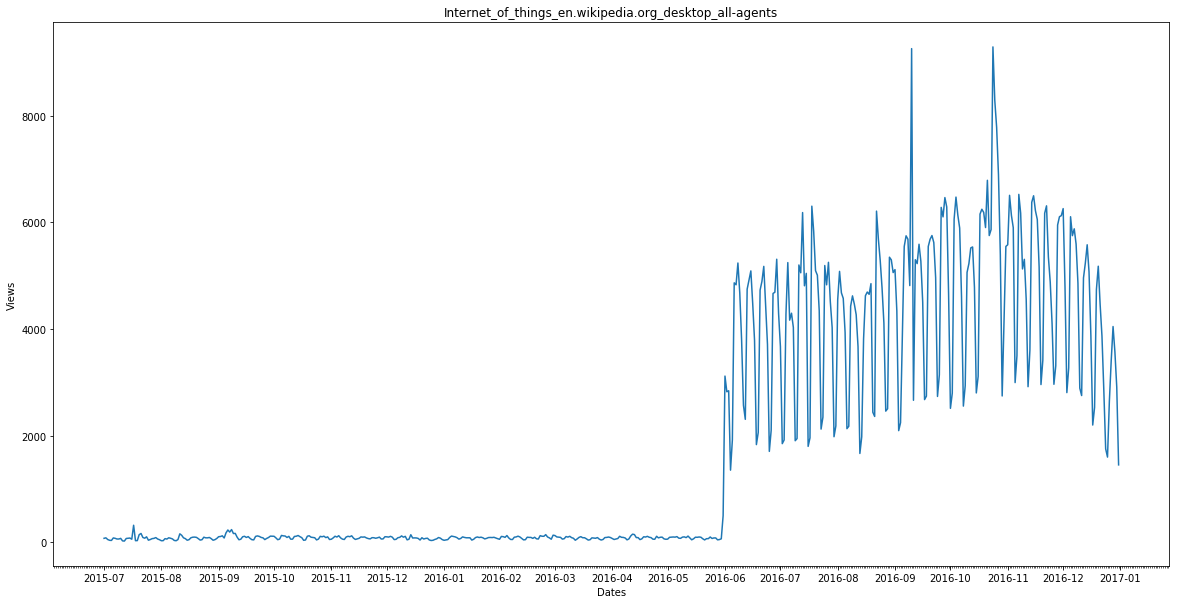

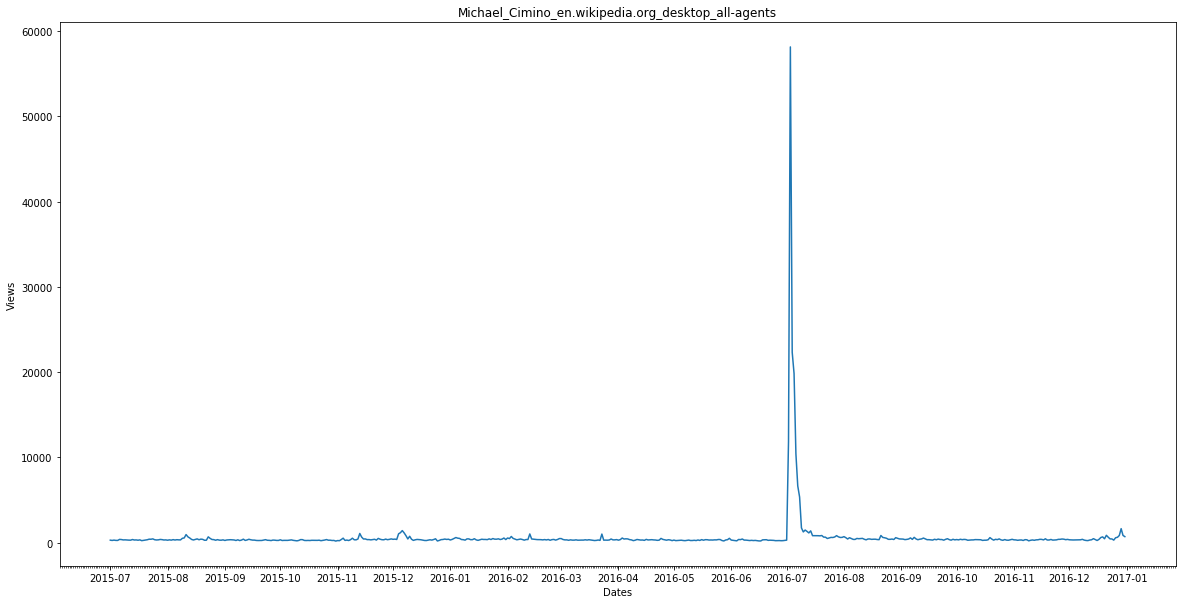

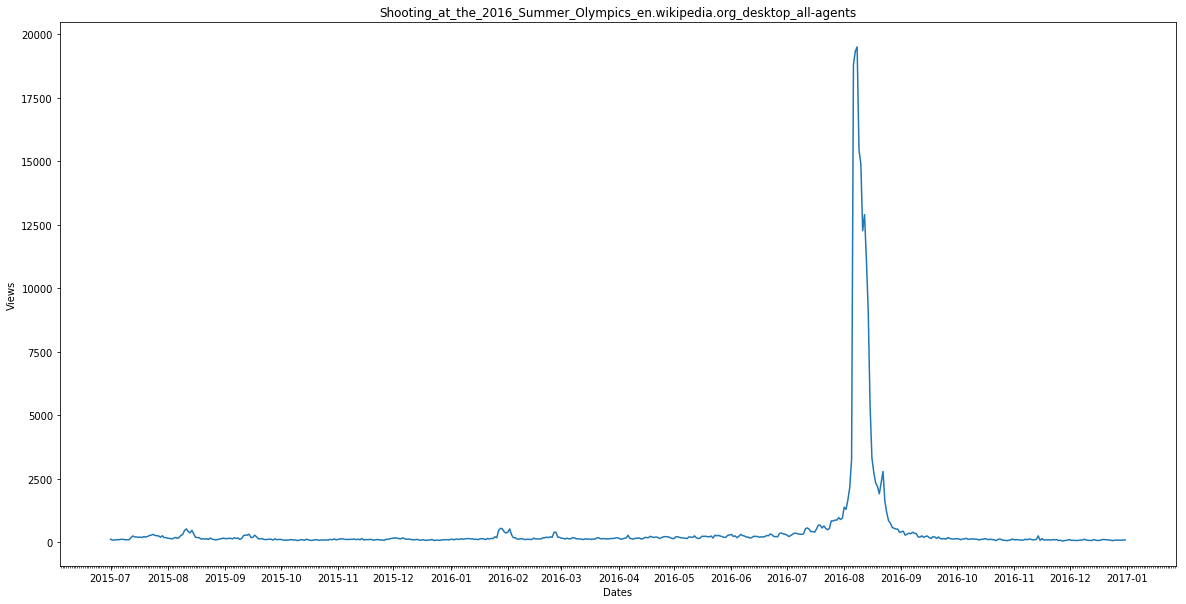

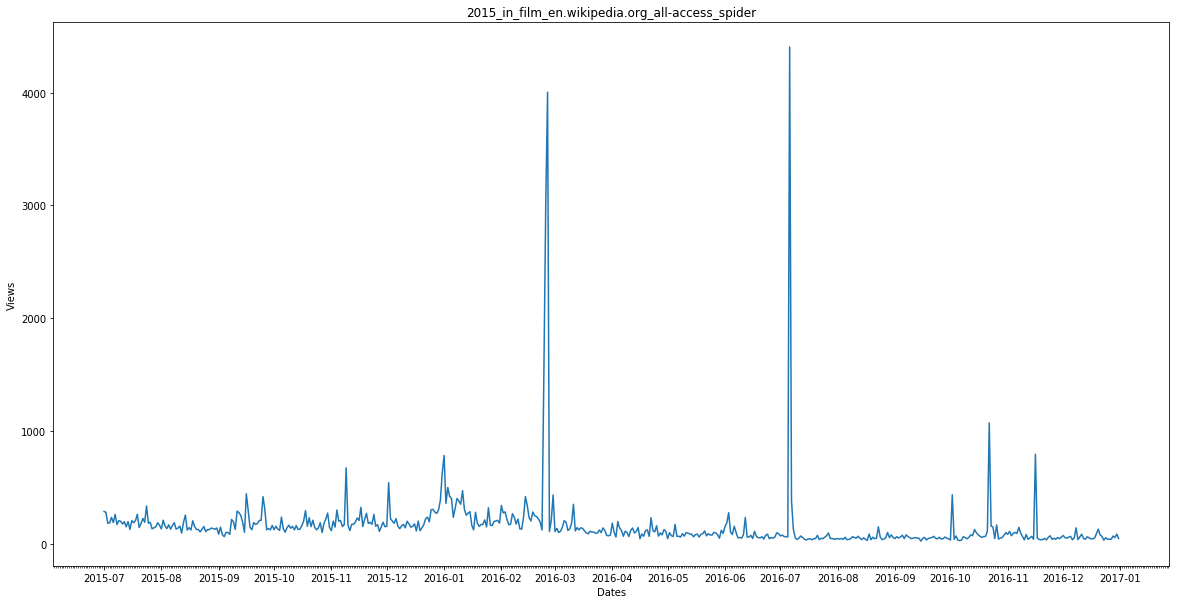

In [13]:
idx = [1, 5, 10, 50, 100, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]
for i in idx:
    plot_entry('en', i)

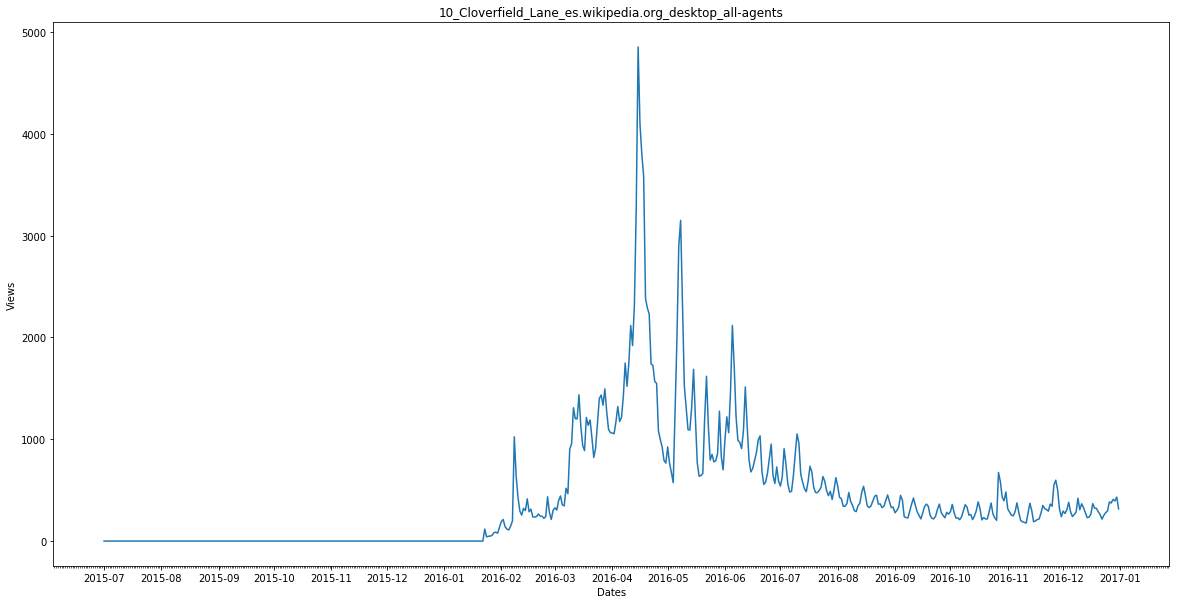

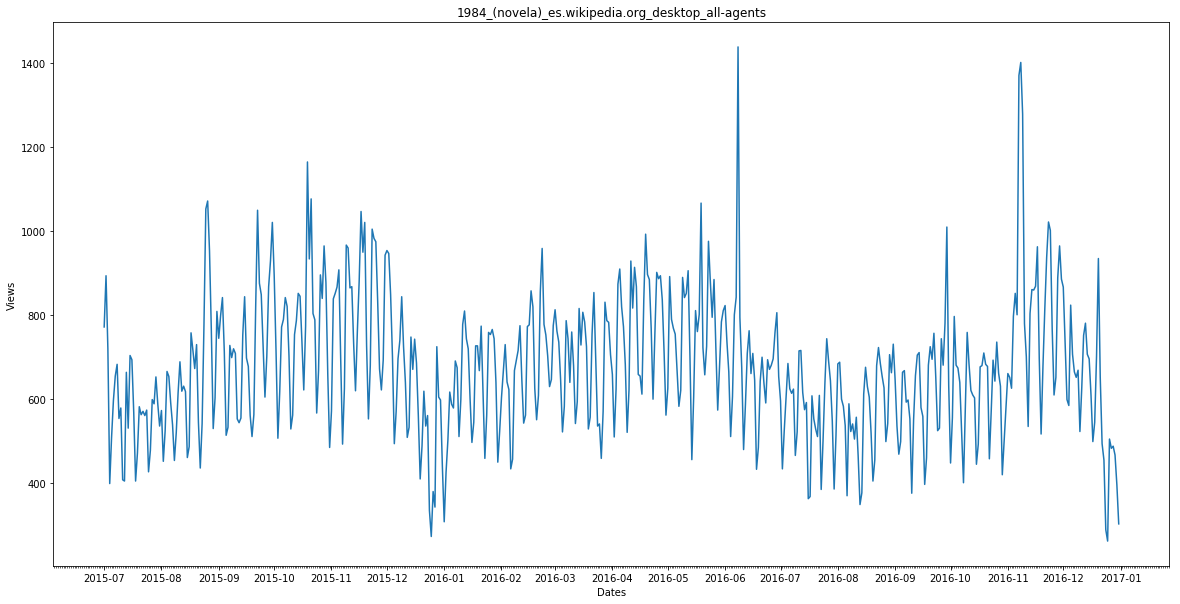

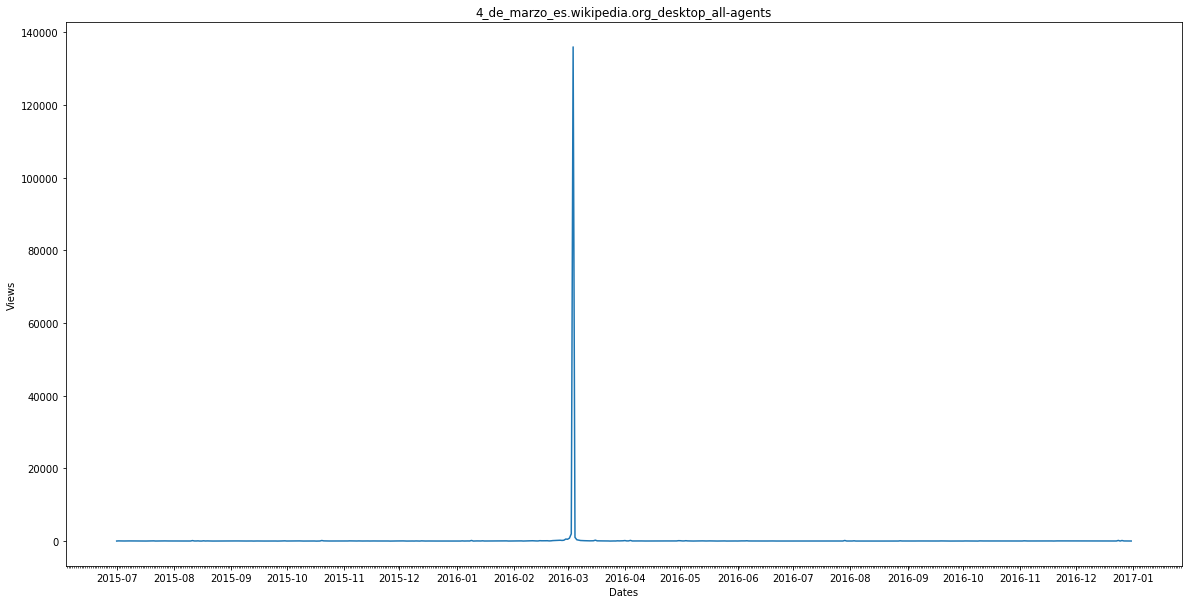

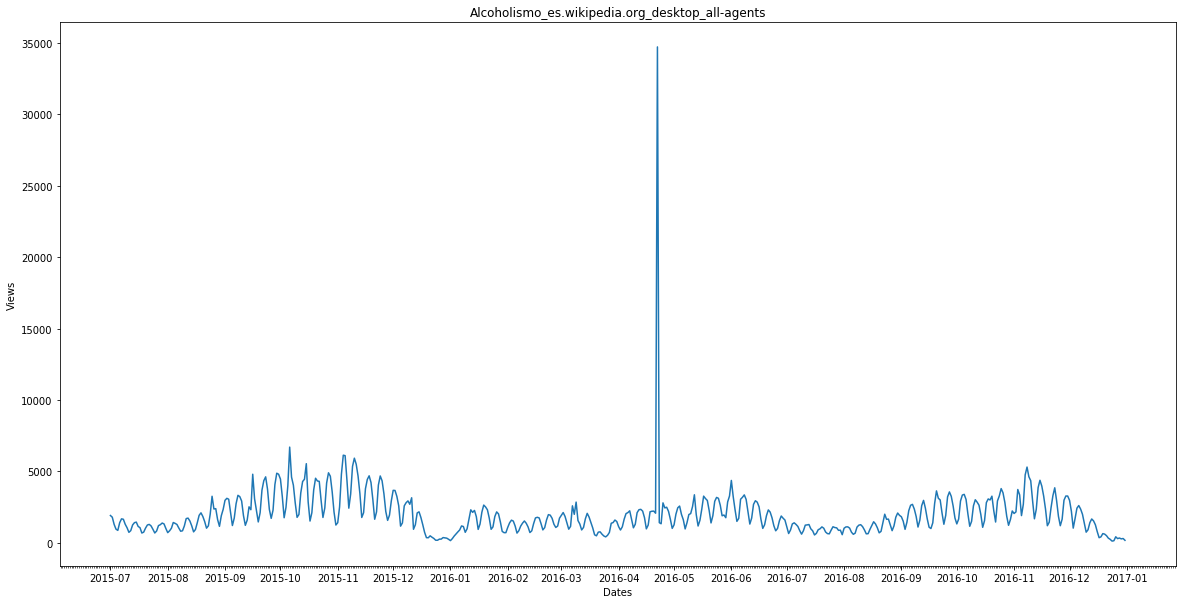

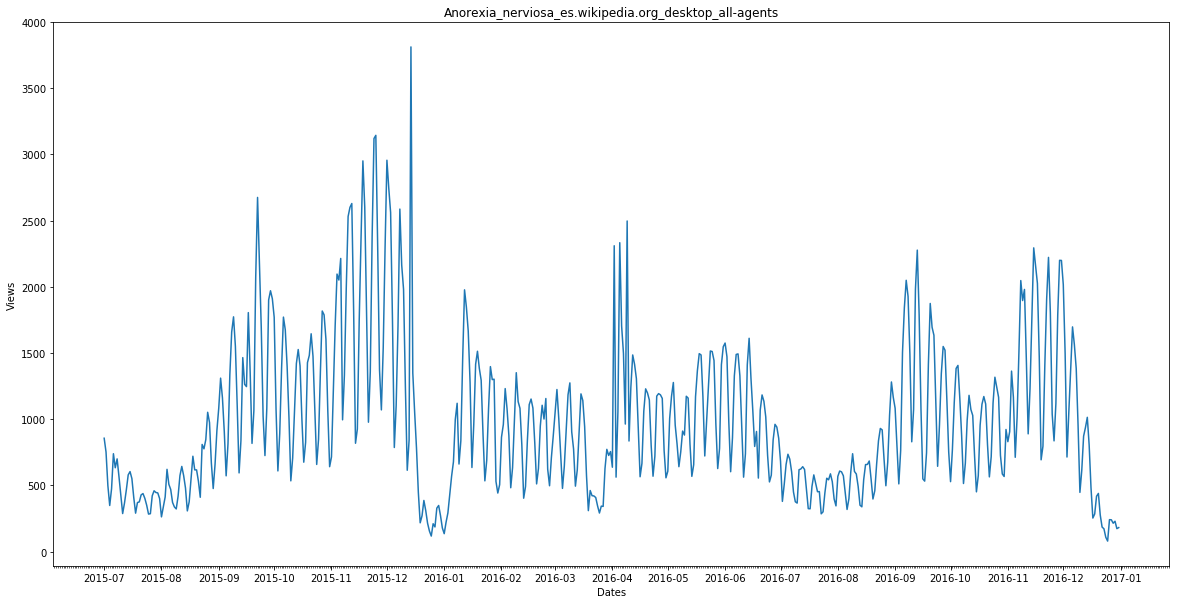

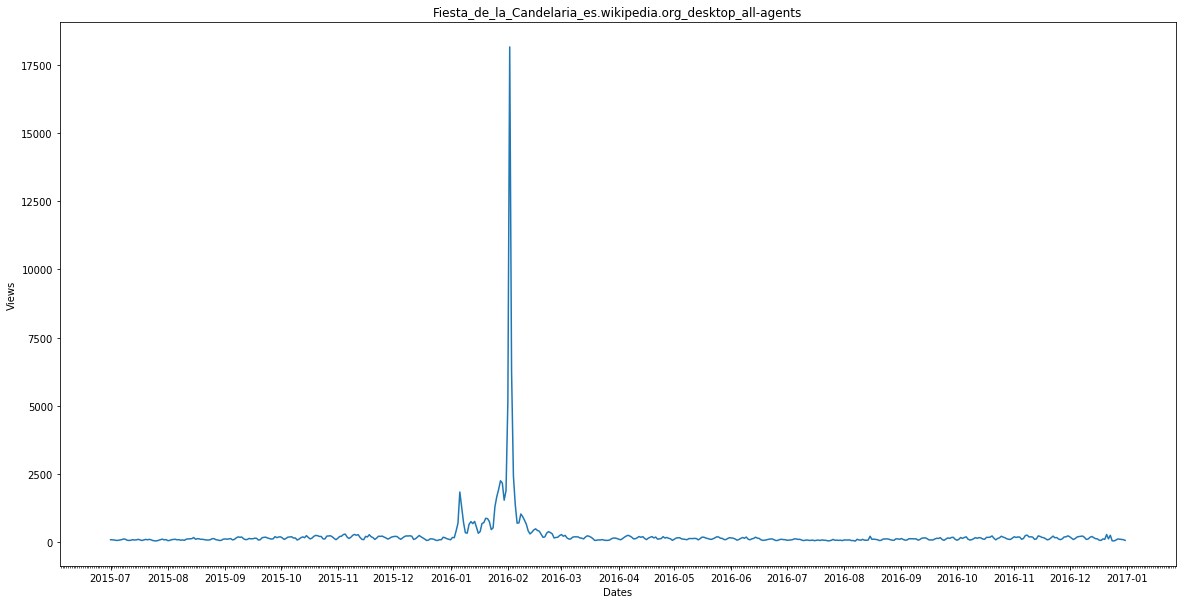

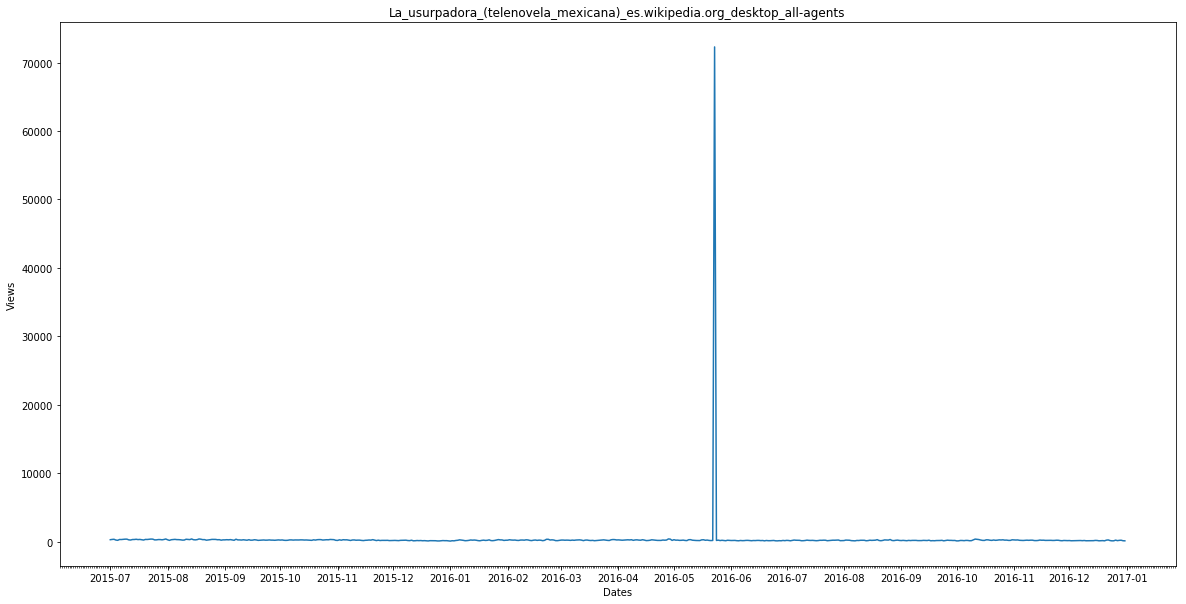

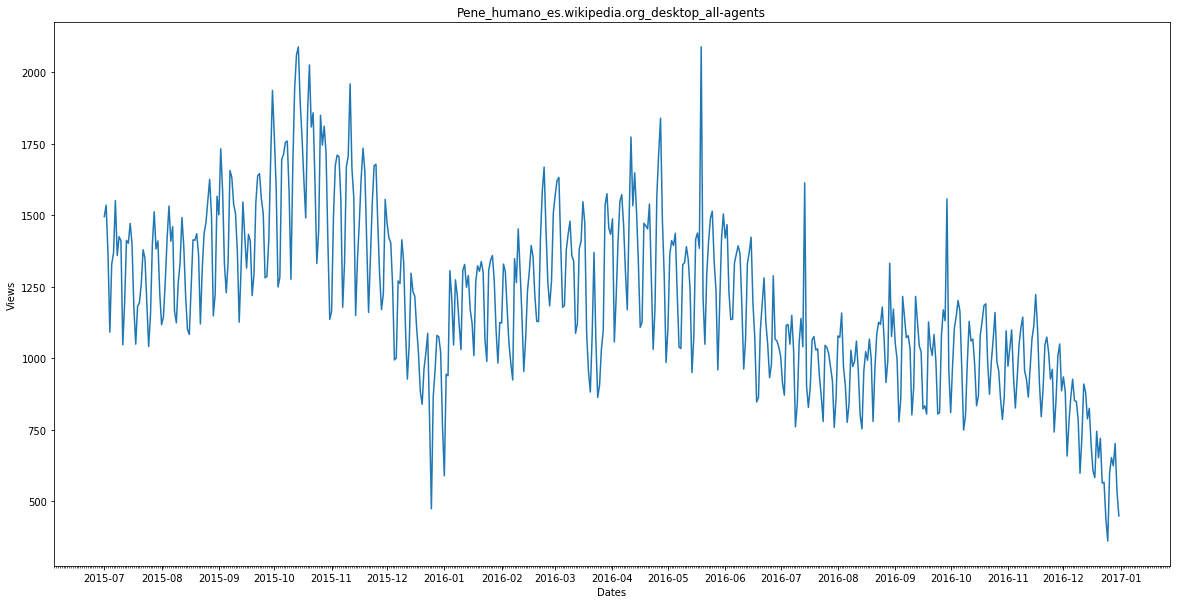

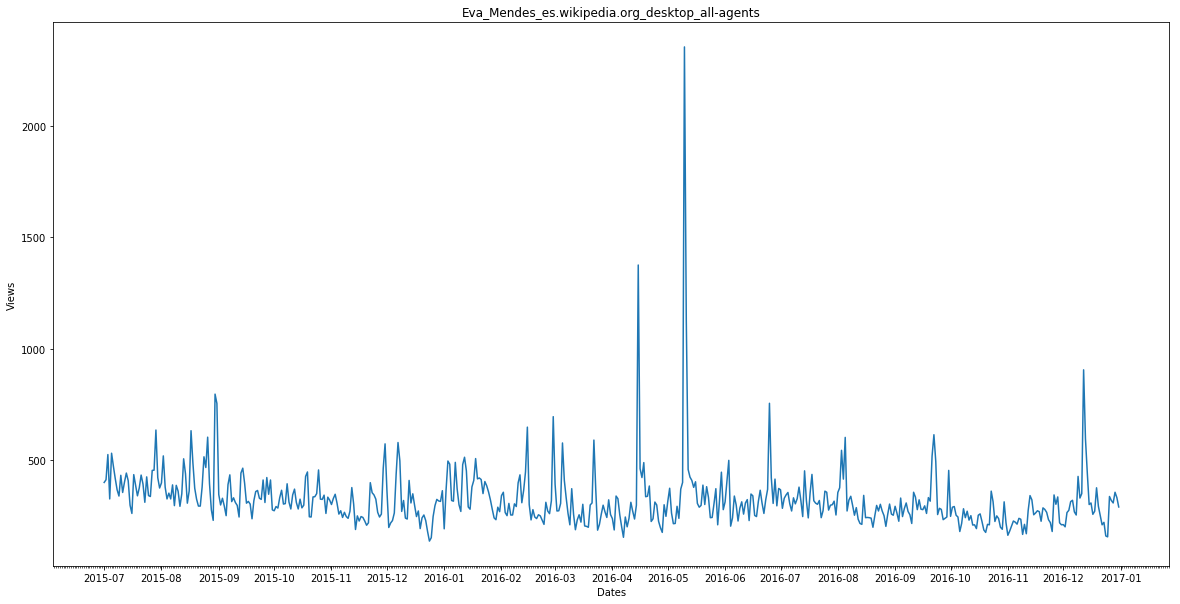

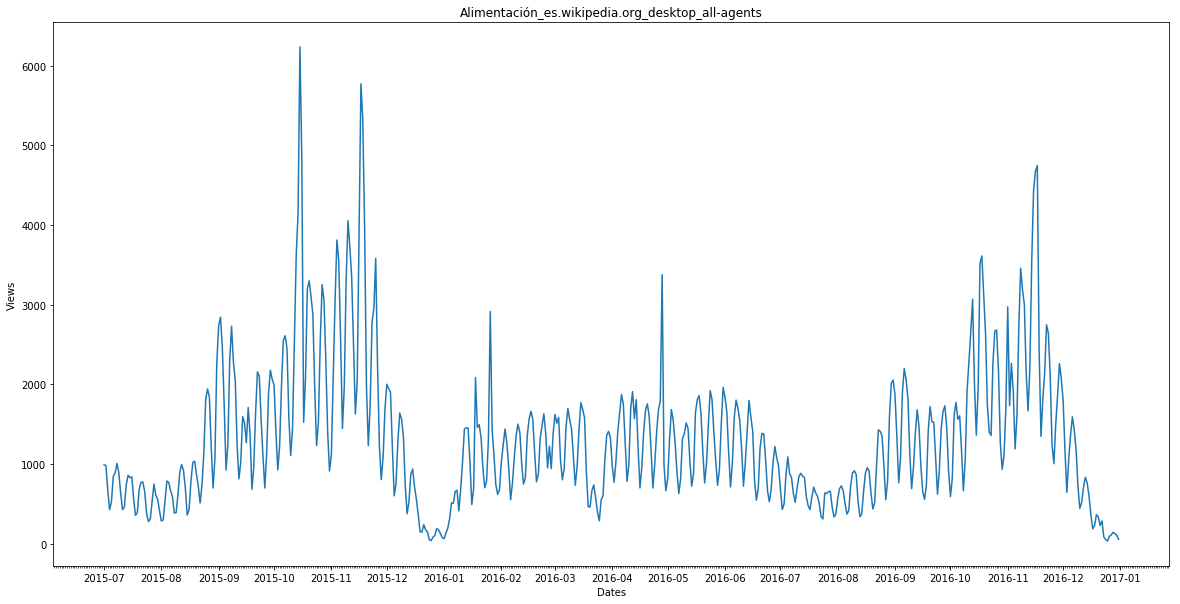

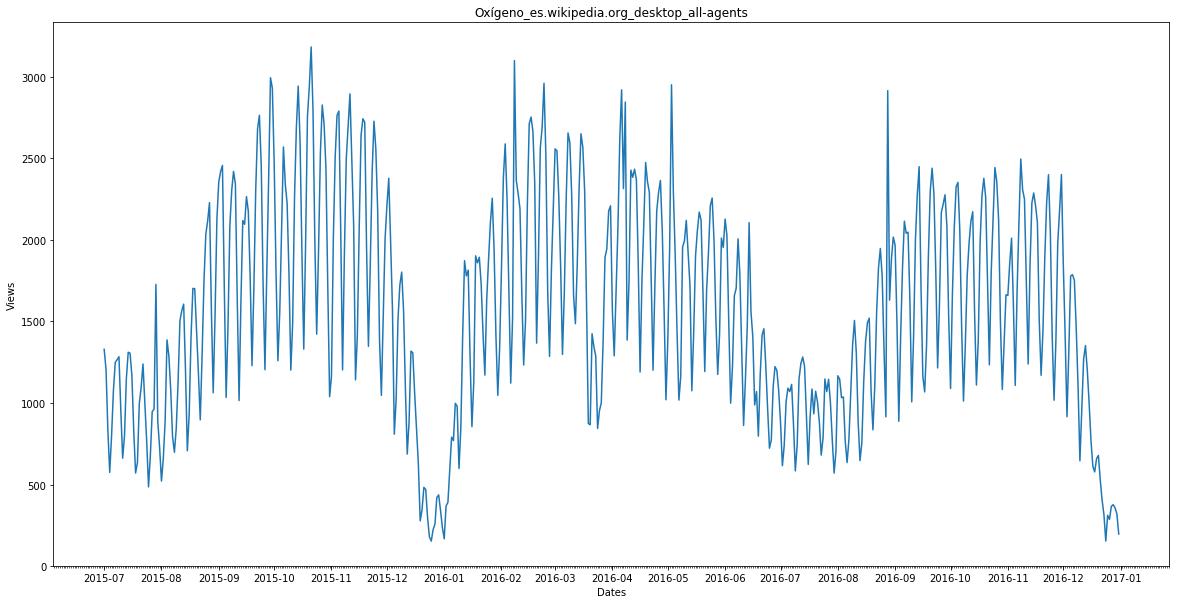

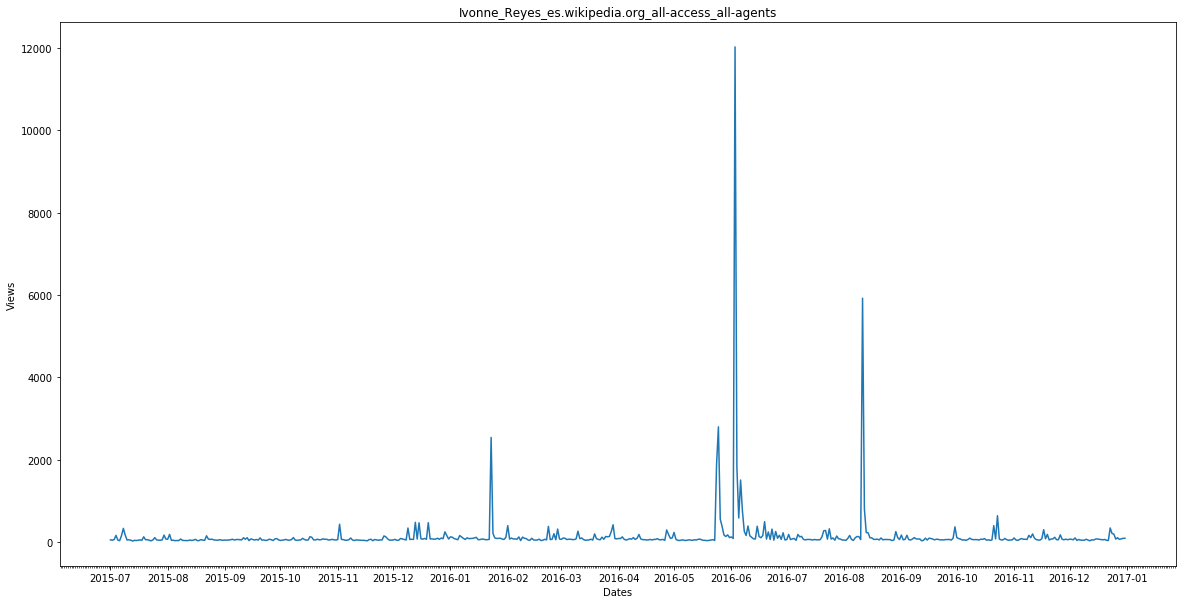

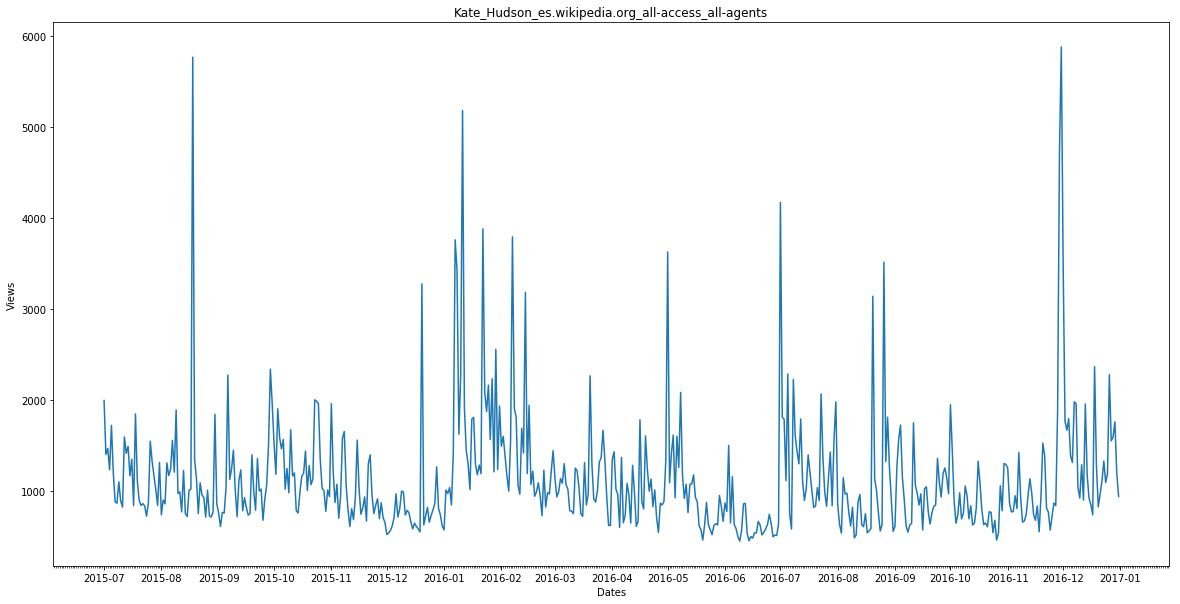

In [14]:
for i in idx:
    plot_entry('es', i)

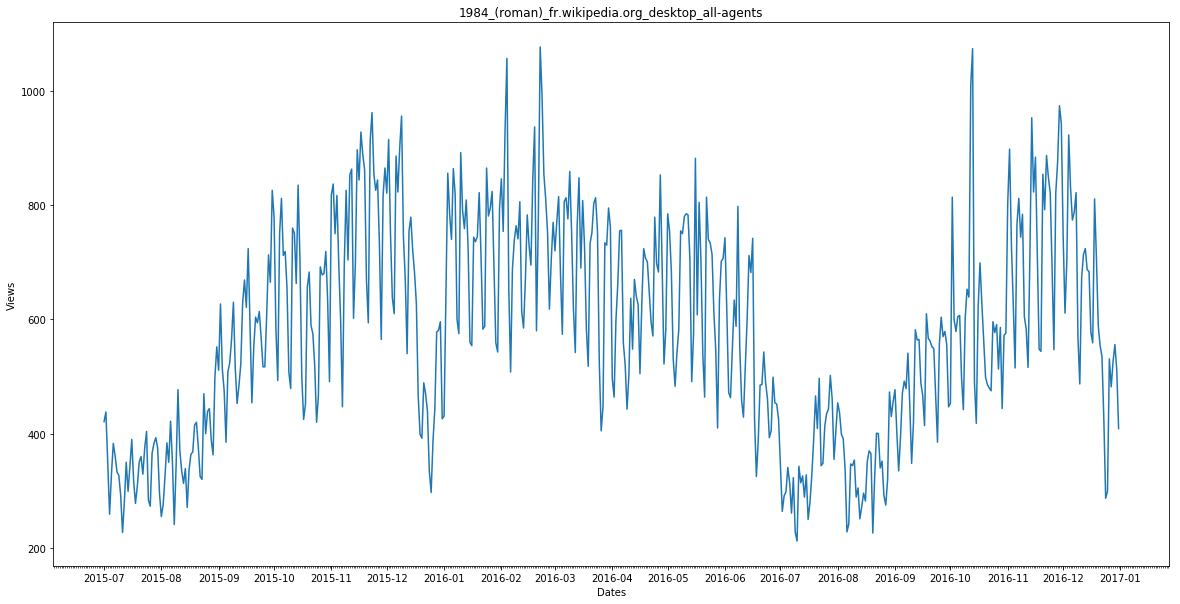

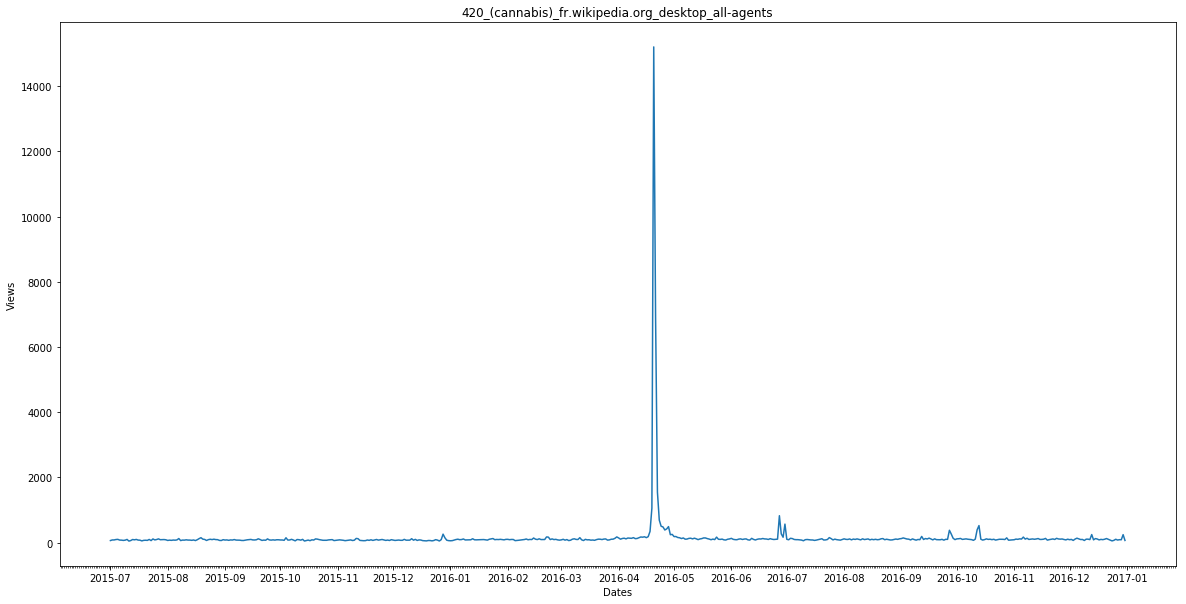

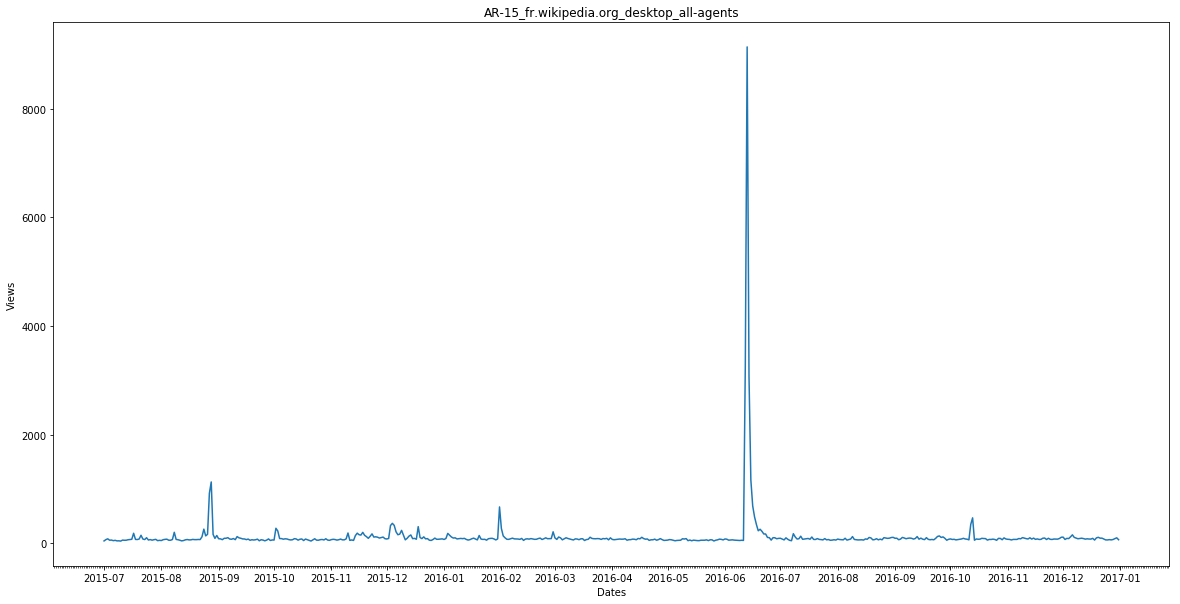

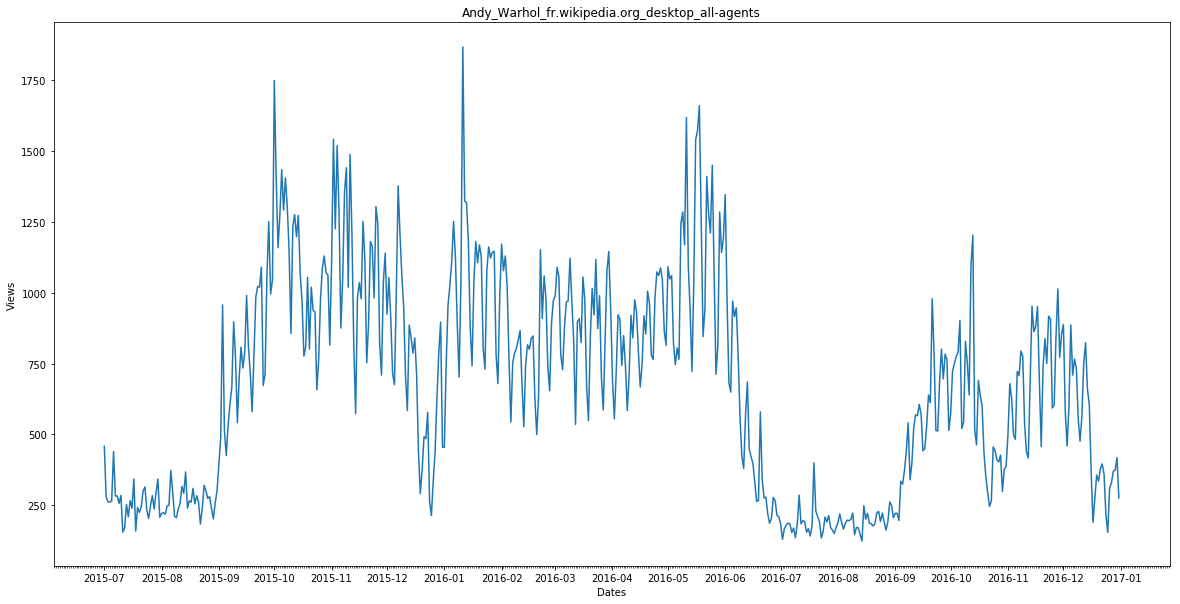

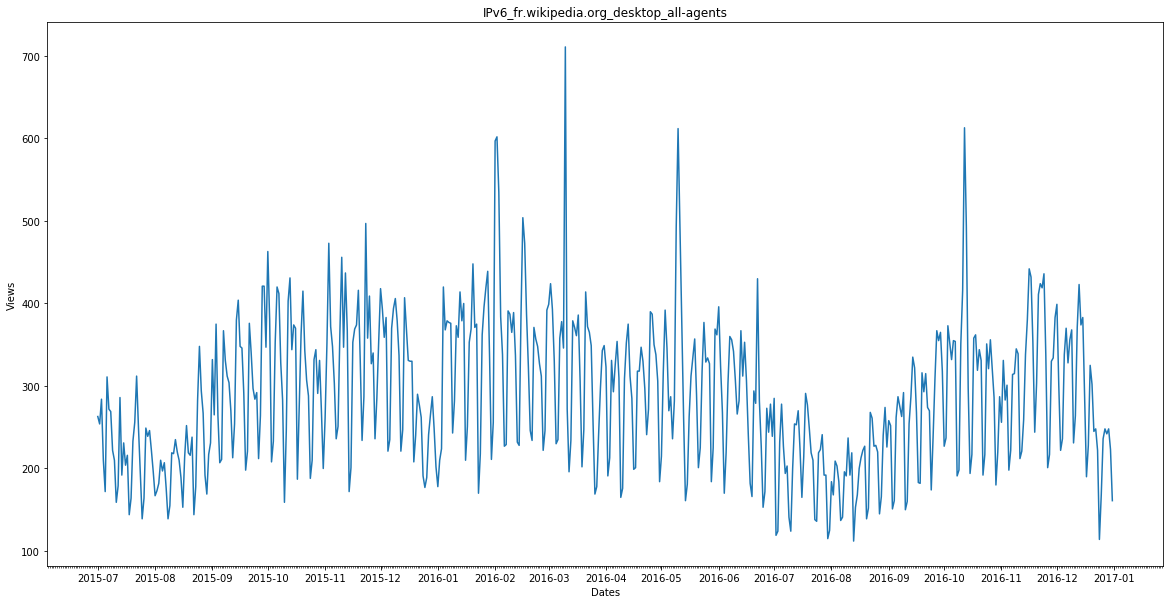

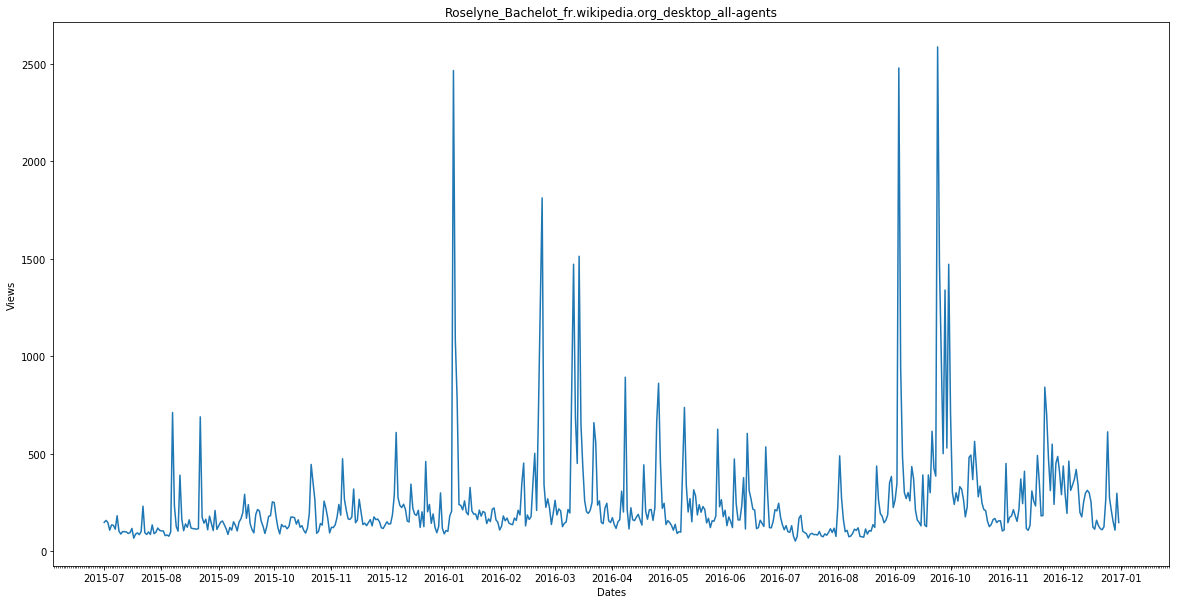

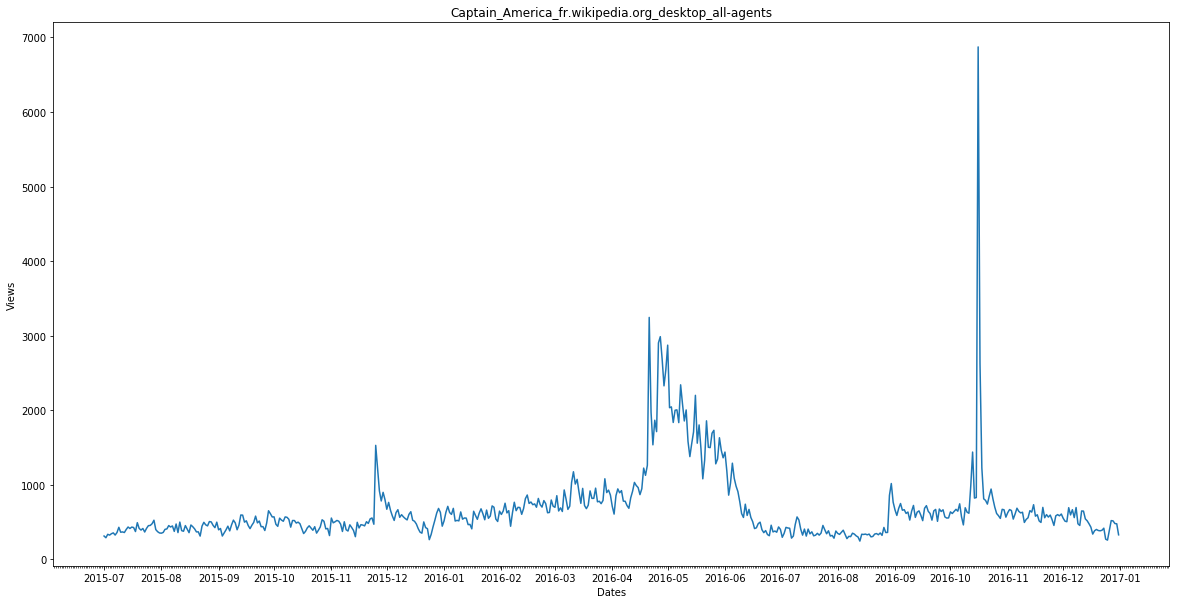

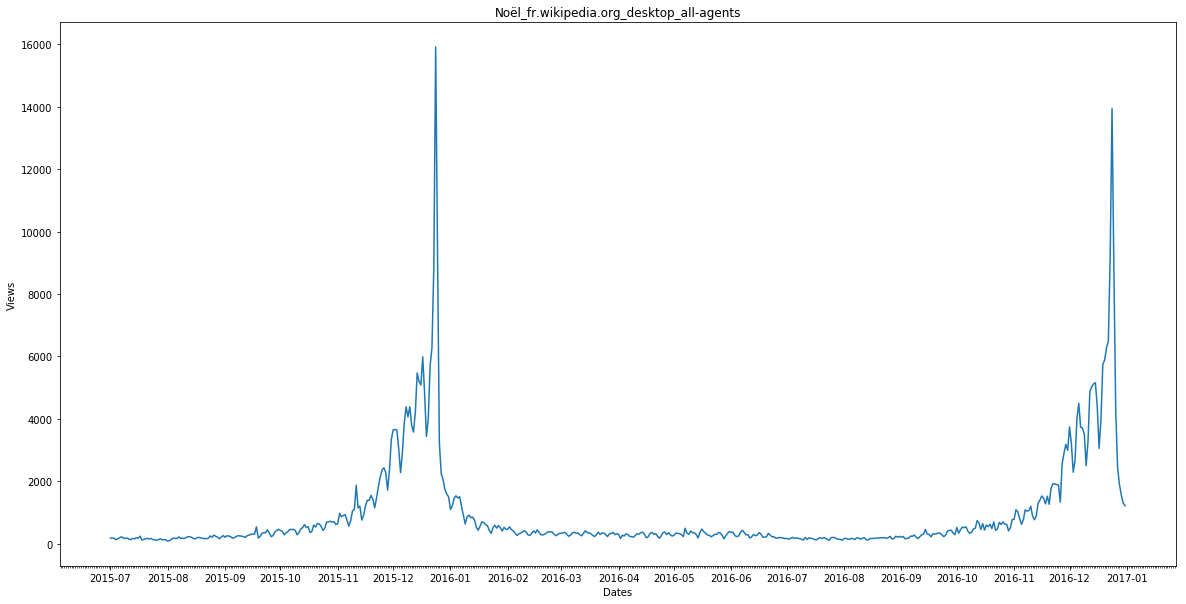

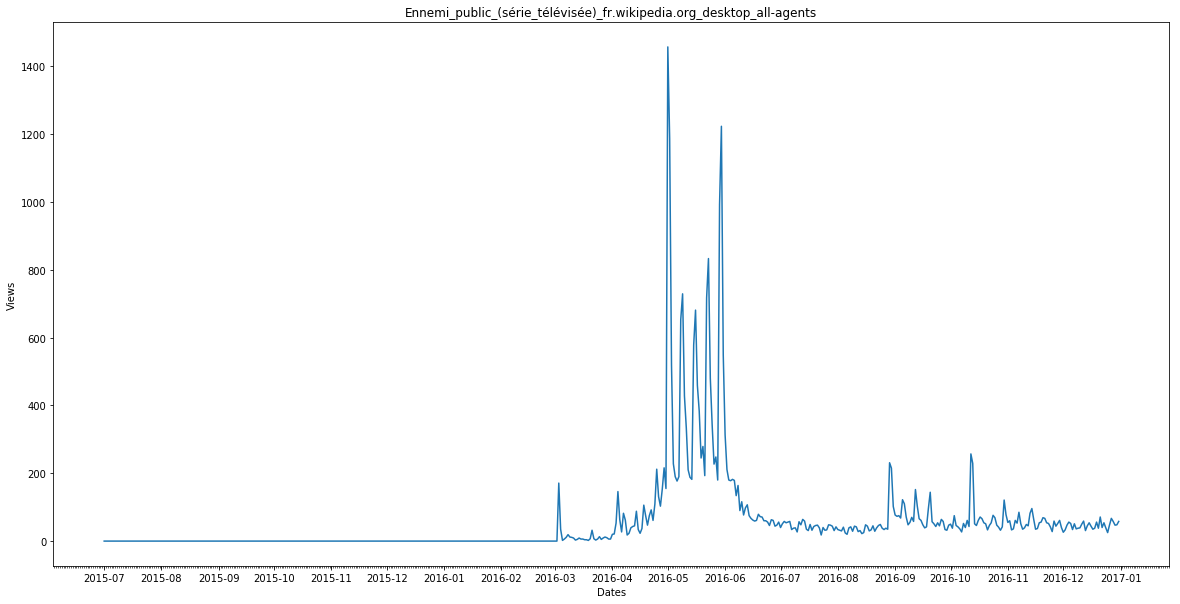

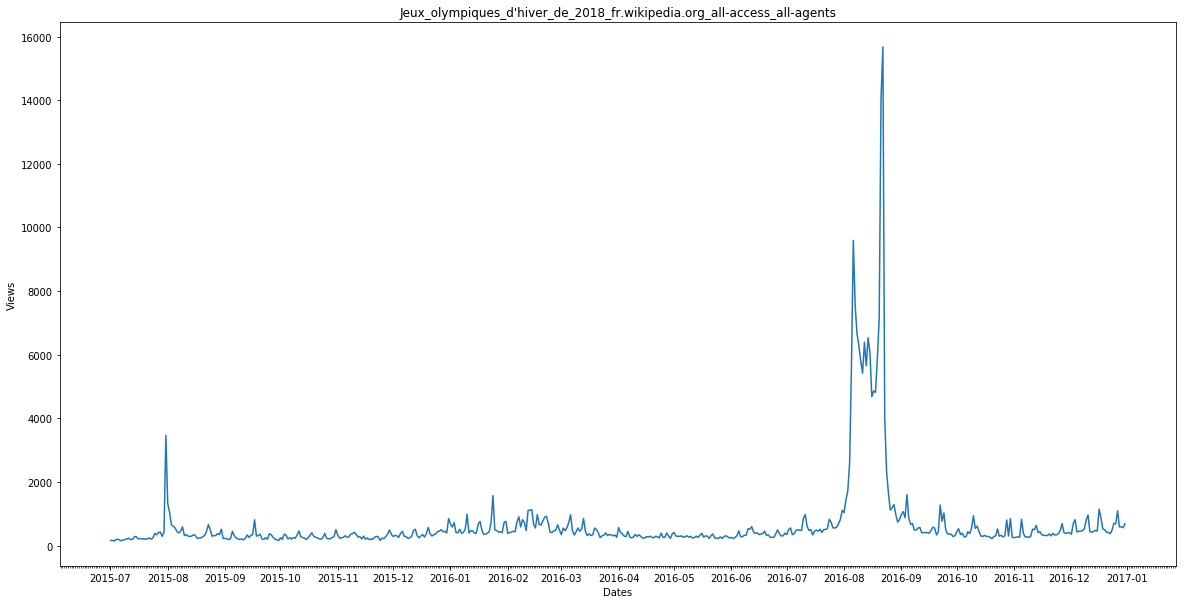

In [15]:
for i in idx:
    plot_entry('fr', i)

In [16]:
# For each language get highest few pages
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page        total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  12066181102
9774       Main_Page_en.wikipedia.org_desktop_all-agents   8774497458
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents   3153984882
39180  Special:Search_en.wikipedia.org_all-access_all...   1304079353
10403  Special:Search_en.wikipedia.org_desktop_all-ag...   1011847748
74690  Special:Search_en.wikipedia.org_mobile-web_all...    292162839
39172  Special:Book_en.wikipedia.org_all-access_all-a...    133993144
10399   Special:Book_en.wikipedia.org_desktop_all-agents    133285908
33644       Main_Page_en.wikipedia.org_all-access_spider    129020407
34257  Special:Search_en.wikipedia.org_all-access_spider    124310206



ja
                                                     Page      total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210753795
86431          メインページ_ja.wikipedia.org_desktop_all-agents  134147415
123025       特

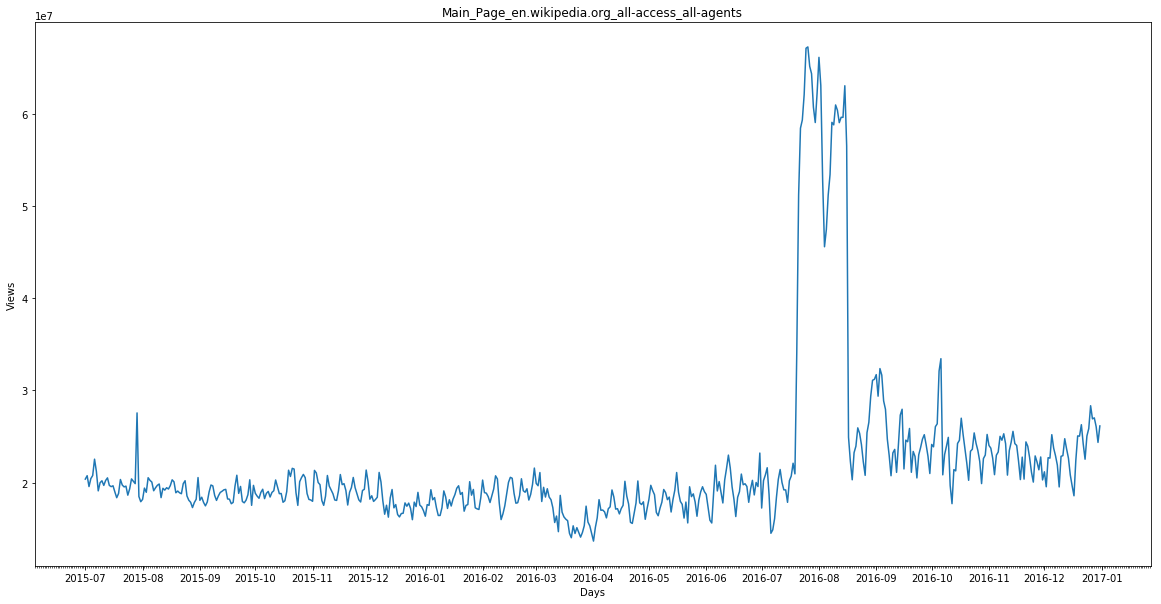

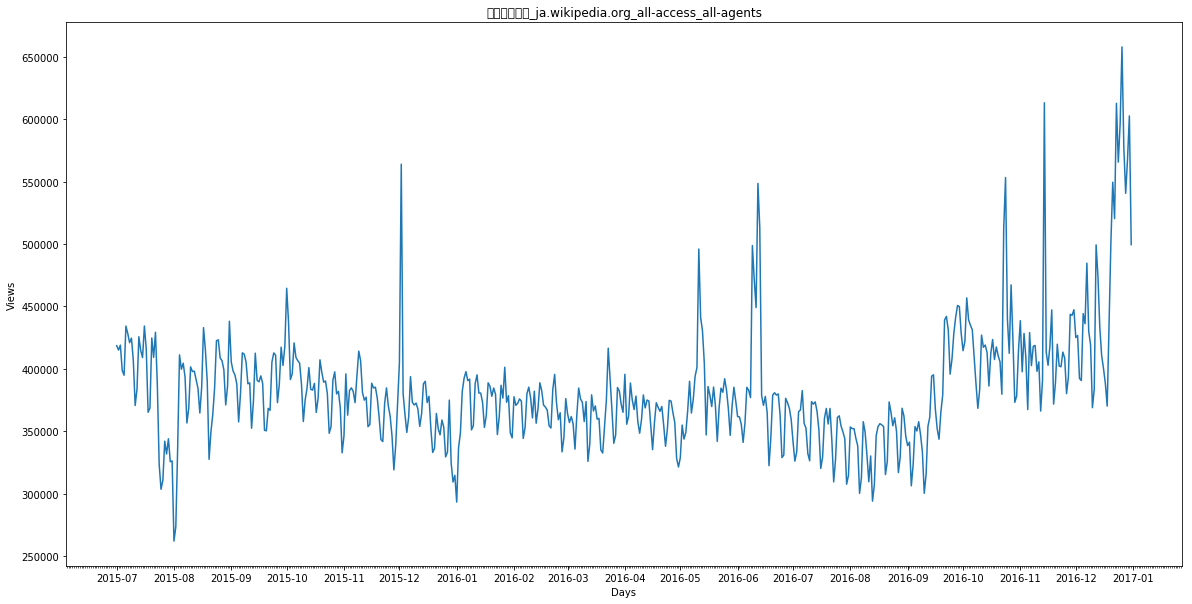

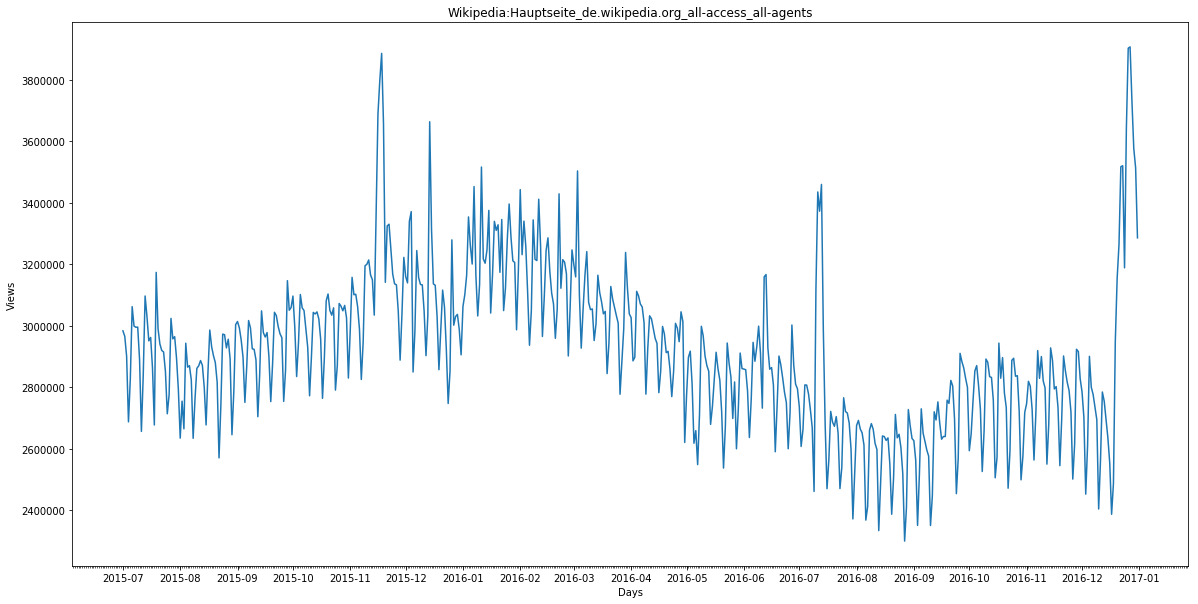

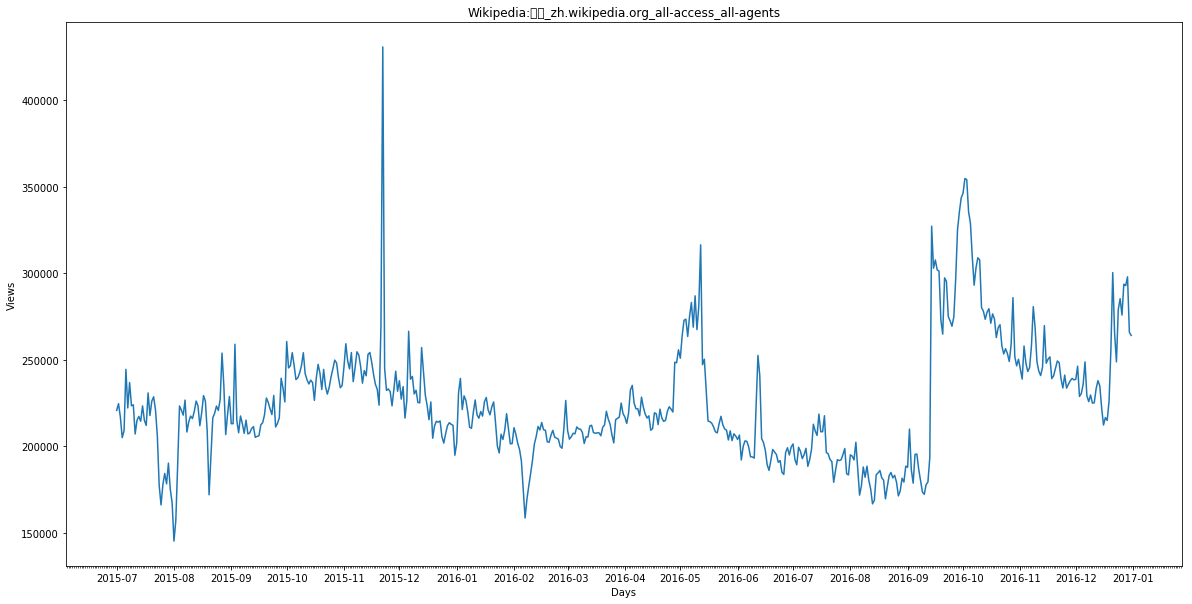

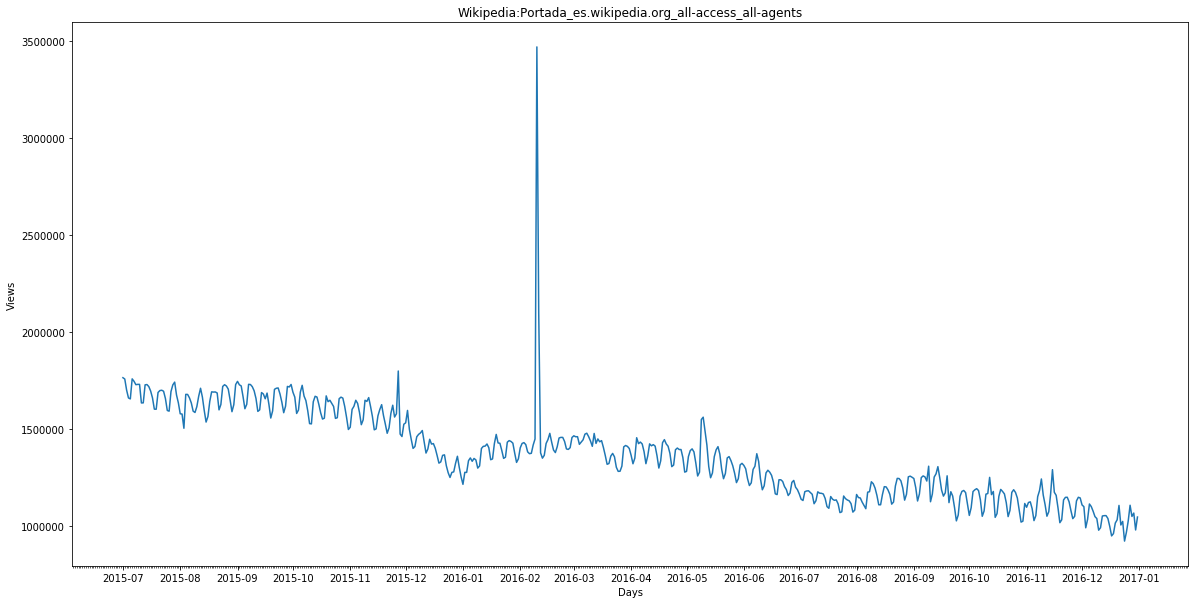

In [17]:
for key in top_pages:
    
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    ymFmt = mdates.DateFormatter('%Y-%m')
    
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key],cols]
    
    ax.plot(dates,data)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(ymFmt)
    ax.xaxis.set_minor_locator(days)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Views')
    ax.set_title(train.loc[top_pages[key],'Page'])
    plt.show()

In [18]:
data = pd.DataFrame(train.loc[top_pages['en'], cols])
data.index = pd.to_datetime(data.index)
type(data.iloc[:, 0])

pandas.core.series.Series

In [19]:
from statsmodels.tsa.stattools import adfuller

list_1 = []
list_2 = []

for key in top_pages:
    print(labels[key])
    data = pd.DataFrame(train.loc[top_pages[key], cols])
    data.index = pd.to_datetime(data.index)
    results = adfuller(data.iloc[:,0], autolag='AIC')
     
    if results[1] < 0.05:
        list_1.append(key)
        
    else: 
        list_2.append(key)
    
    resultsOutput = pd.Series(results[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        resultsOutput['Critical Value (%s)'%key] = value
    print(resultsOutput)
    print('\n')
    
   

        
print(list_1)
print('\n')
print(list_2)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


English
Test Statistic                  -2.990145
p-value                          0.035825
#Lags Used                      15.000000
Number of Observations Used    534.000000
Critical Value (1%)             -3.442655
Critical Value (5%)             -2.866968
Critical Value (10%)            -2.569661
dtype: float64


Japanese
Test Statistic                  -1.429105
p-value                          0.568246
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


German
Test Statistic                  -1.520025
p-value                          0.523583
#Lags Used                      19.000000
Number of Observations Used    530.000000
Critical Value (1%)             -3.442749
Critical Value (5%)             -2.867009
Critical Value (10%)            -2.569683
dtype: float64


Media
Test Statistic                  -2.97

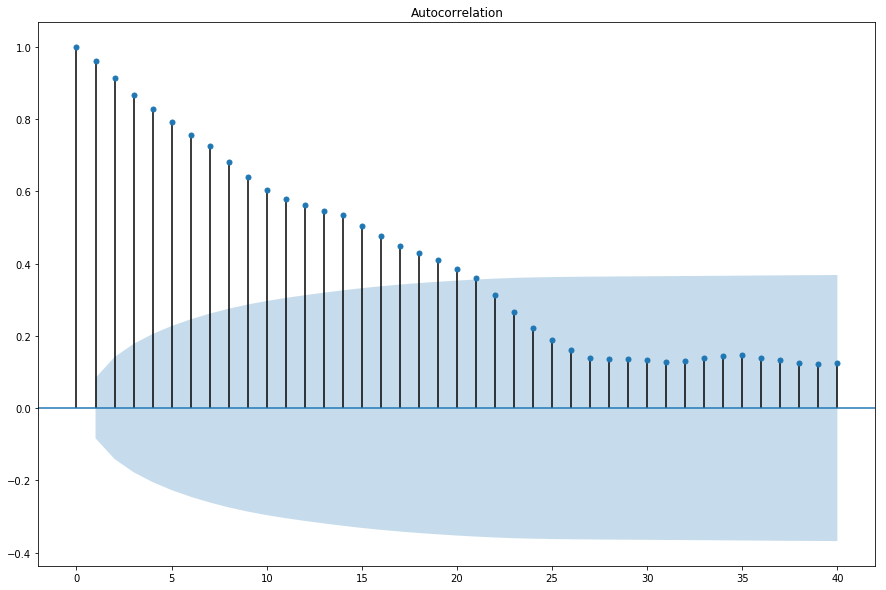

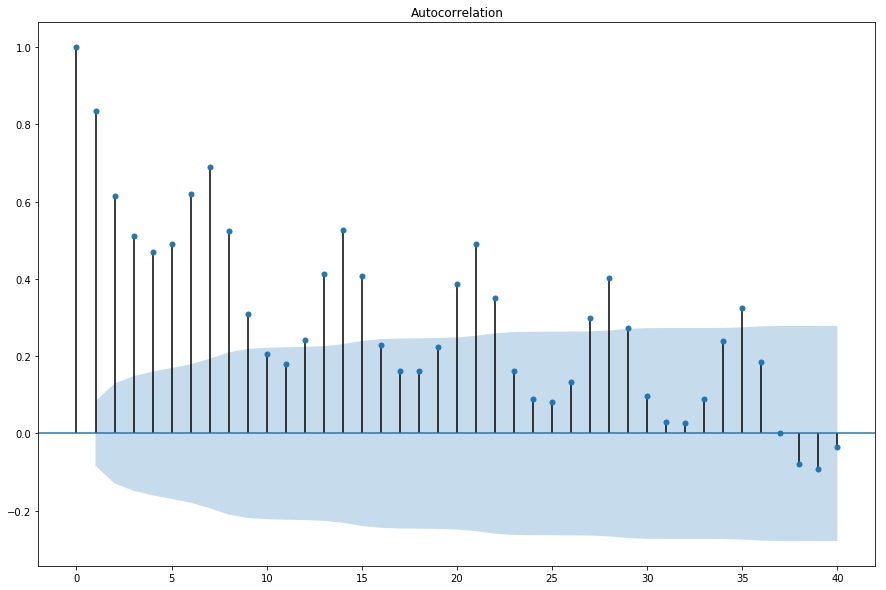

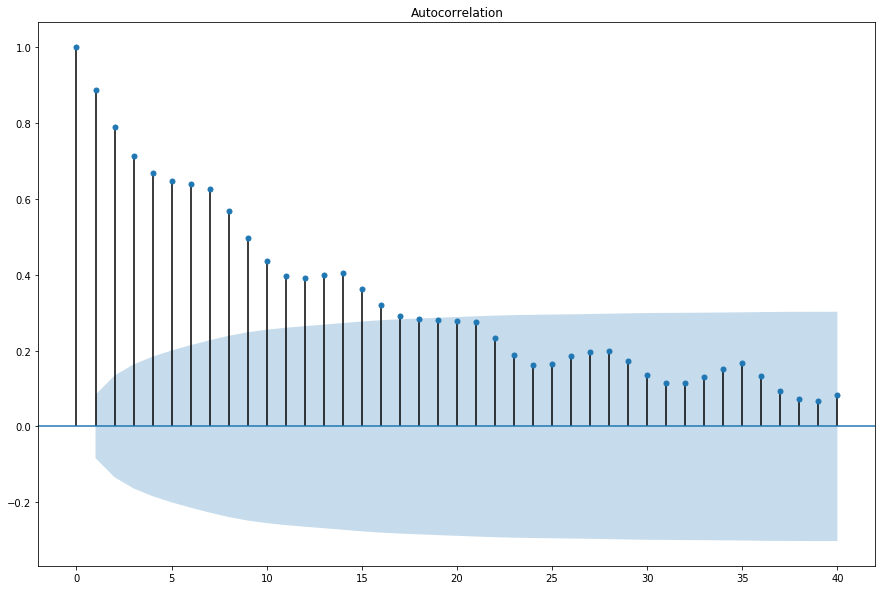

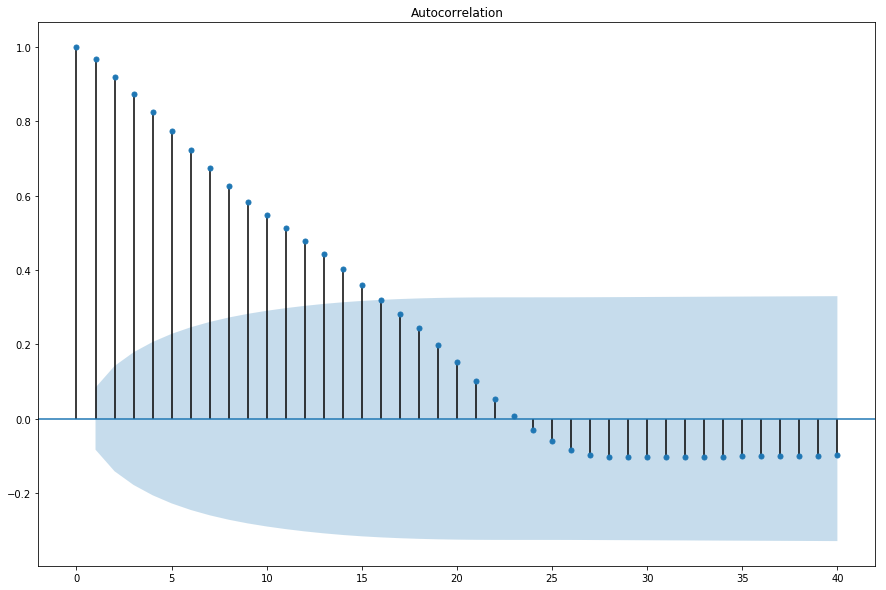

In [20]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for str in list_1:
    
    #print('Autocorrelation_'+ labels[str])
    
    data = pd.DataFrame(train.loc[top_pages[str], :])
    #data.index = pd.to_datetime(data.index)
    
    #print(acf(data))
    fig, ax = plt.subplots(1,1, figsize=(15, 10))
    plot_acf(data.iloc[1:-1, :].astype(float), lags = 40, alpha = 0.05, ax=ax)
    
    print('\n')
    #plot_acf(data, alpha=0.05, title='Partial Autocorrelation_' + key)

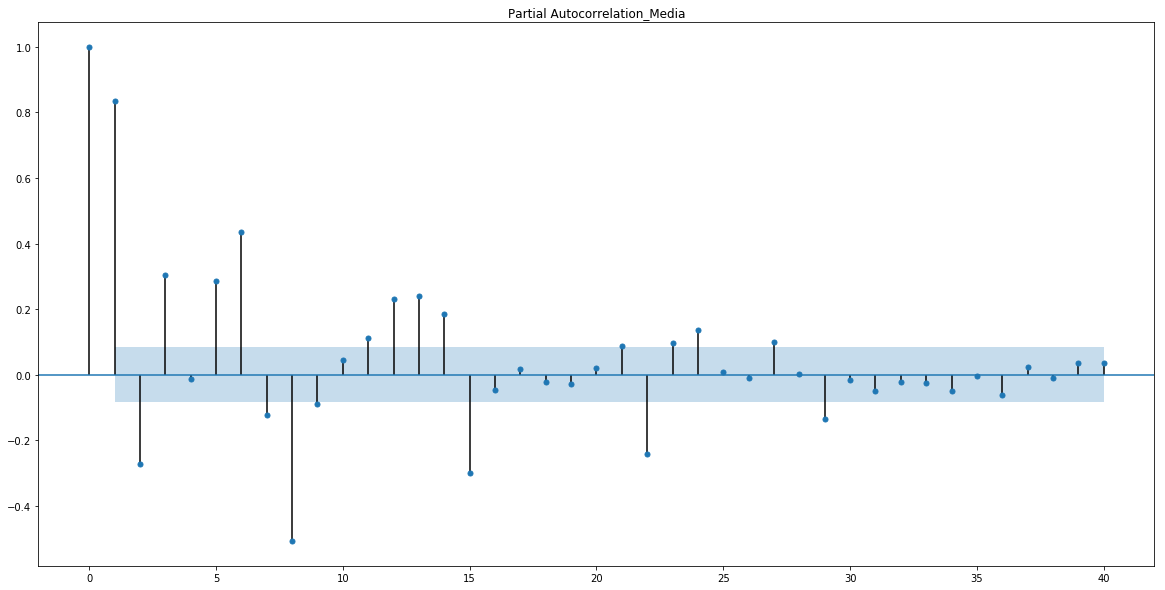

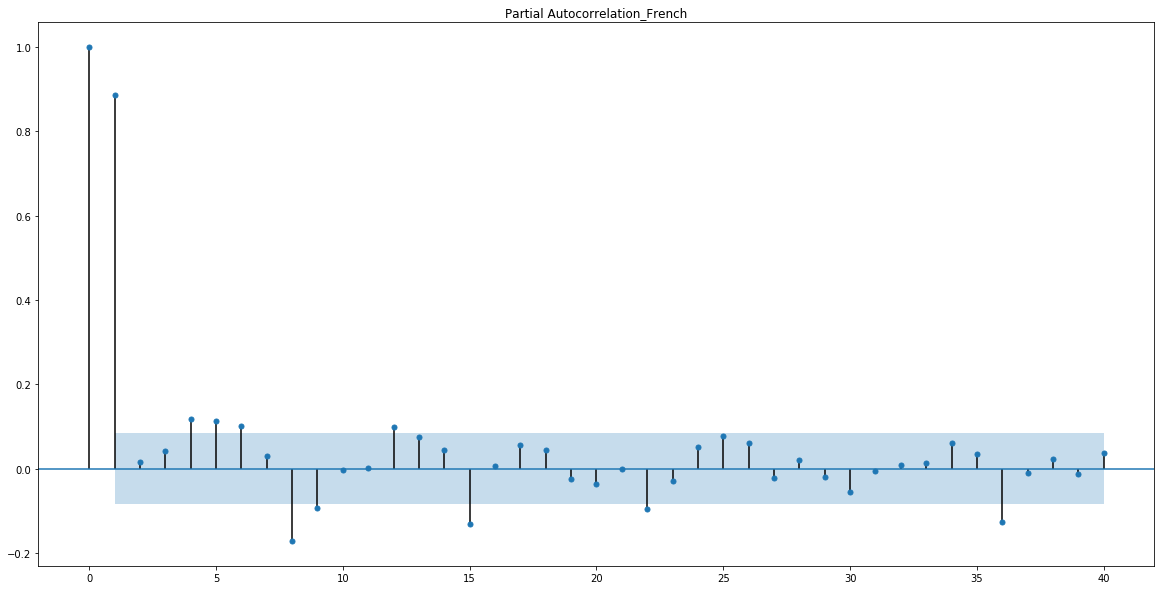

In [21]:
for str in list_1:
    data = pd.DataFrame(train.loc[top_pages[str], :])
    
    #data.index = pd.to_datetime(data.index)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plot_pacf(data.iloc[1:-1, :].astype(float), lags = 40, alpha=0.05, title='Partial Autocorrelation_' + labels[str], ax=ax)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


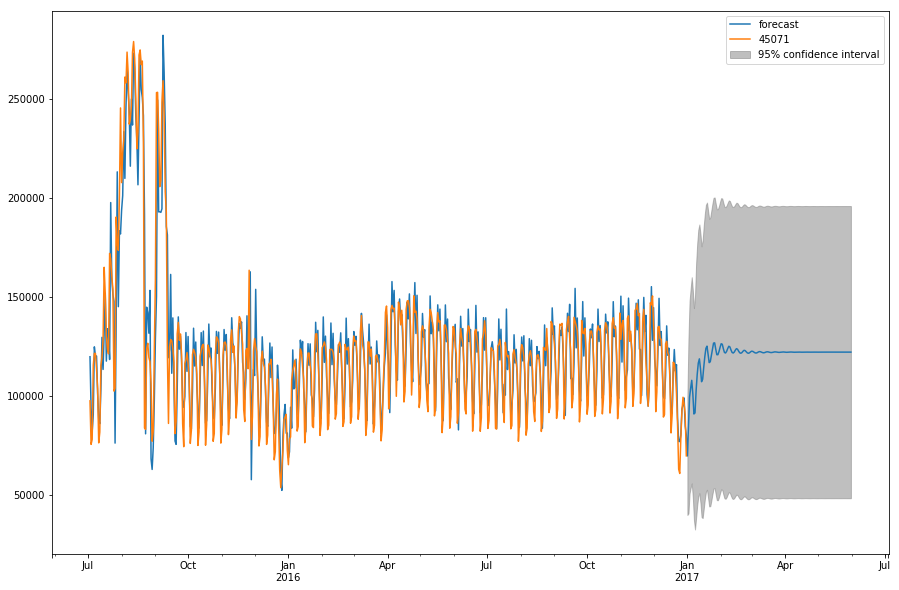

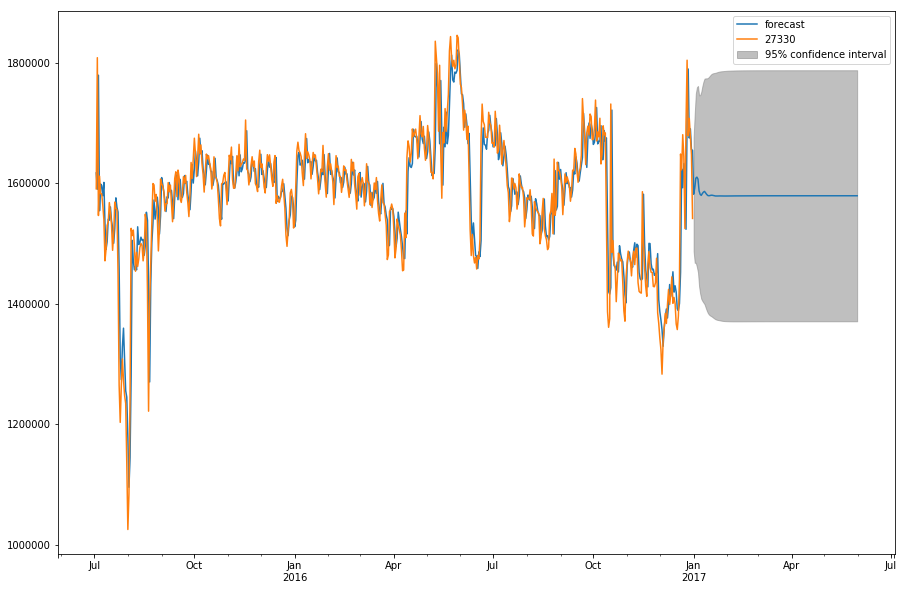

In [22]:
from statsmodels.tsa.arima_model import ARMA

for str in list_1:
    
    data = pd.DataFrame(train.loc[top_pages[str], :])

#print(data.iloc[1:-1, 0])
    mod = ARMA(data.iloc[1:-1, 0].astype(float), order=(7, 1))
    res = mod.fit()
    
    # Plot the original series and the forecasted series
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    res.plot_predict(start='2015-7-3', end='2017-5-31', ax=ax)
    plt.show()
    

In [23]:
for i in list_2:
    data = pd.DataFrame(train.loc[top_pages[i], :])
    data = data.iloc[1:-1, :]
    chg_data = data.diff(1)
    chg_data = chg_data.dropna()
    results = adfuller(chg_data.iloc[:, 0].astype(float), autolag='AIC')
    
    resultsOutput = pd.Series(results[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in results[4].items():
        resultsOutput['Critical Value (%s)'%key] = value

    print(resultsOutput)

    print('\n')
    

Test Statistic                -8.301575e+00
p-value                        4.005172e-13
#Lags Used                     1.900000e+01
Number of Observations Used    5.290000e+02
Critical Value (1%)           -3.442772e+00
Critical Value (5%)           -2.867019e+00
Critical Value (10%)          -2.569688e+00
dtype: float64


Test Statistic                -7.238942e+00
p-value                        1.906705e-10
#Lags Used                     1.900000e+01
Number of Observations Used    5.290000e+02
Critical Value (1%)           -3.442772e+00
Critical Value (5%)           -2.867019e+00
Critical Value (10%)          -2.569688e+00
dtype: float64


Test Statistic                -7.298885e+00
p-value                        1.354998e-10
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (1%)           -3.442632e+00
Critical Value (5%)           -2.866957e+00
Critical Value (10%)          -2.569655e+00
dtype: float64


Test Statistic           

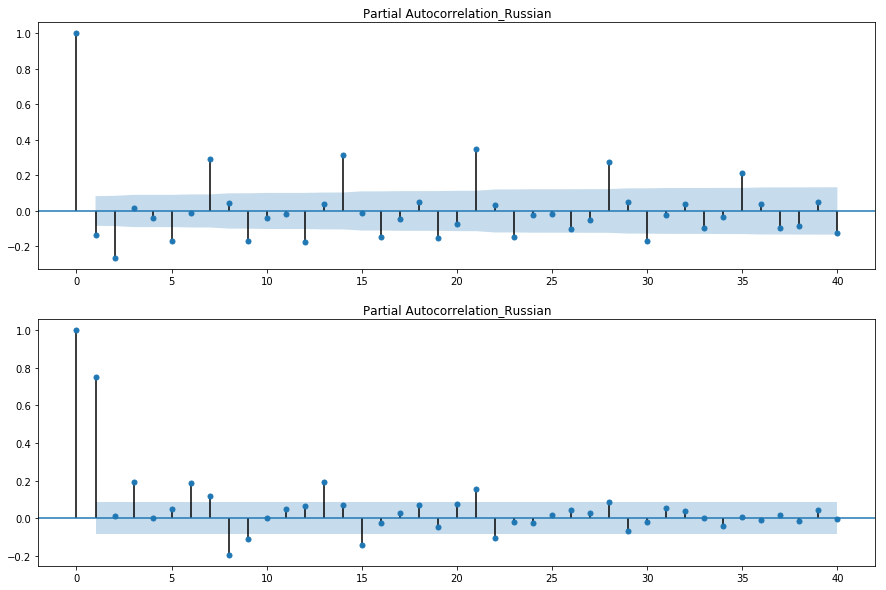

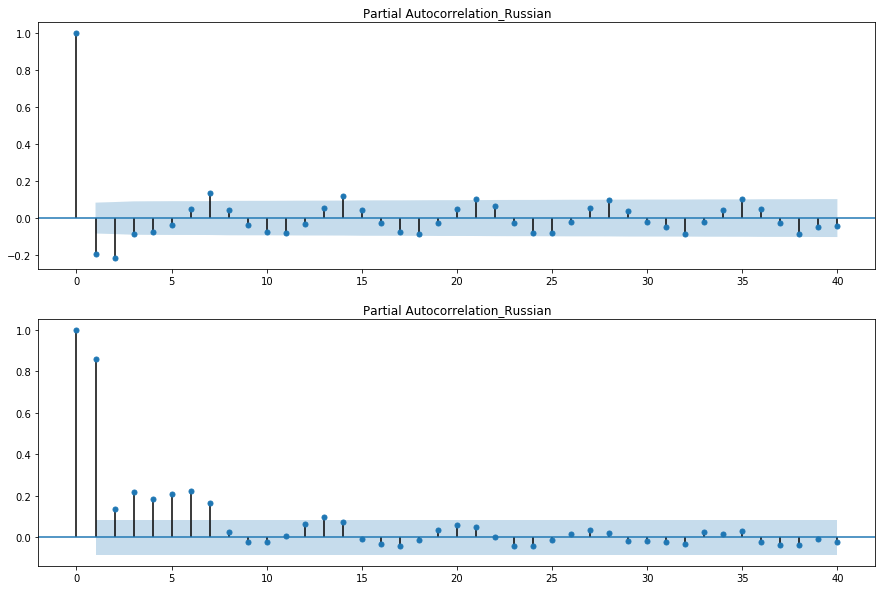

In [24]:
for i in list_2:
    data = pd.DataFrame(train.loc[top_pages[i], :])
    data = data.iloc[1:-1, :]
    chg_data = data.diff(1)
    chg_data = chg_data.dropna()
    
    fig, axes = plt.subplots(2,1, figsize=(15, 10))
    plot_acf(chg_data.astype(float), title='Partial Autocorrelation_' + labels[str], lags = 40, alpha = 0.05, ax=axes[0])
    plot_pacf(data.iloc[1:-1, :].astype(float), lags = 40, alpha=0.05, title='Partial Autocorrelation_' + labels[str], ax=axes[1])
    

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


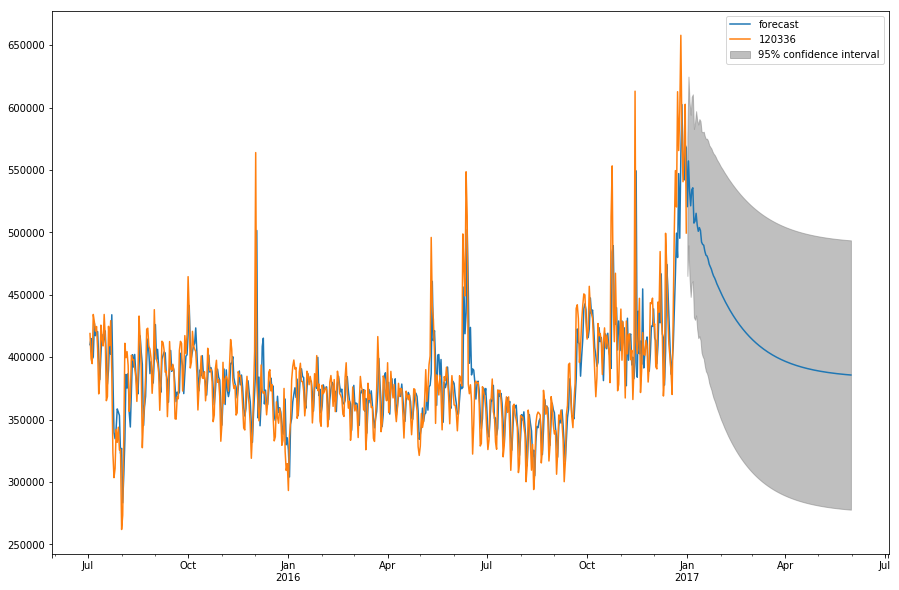

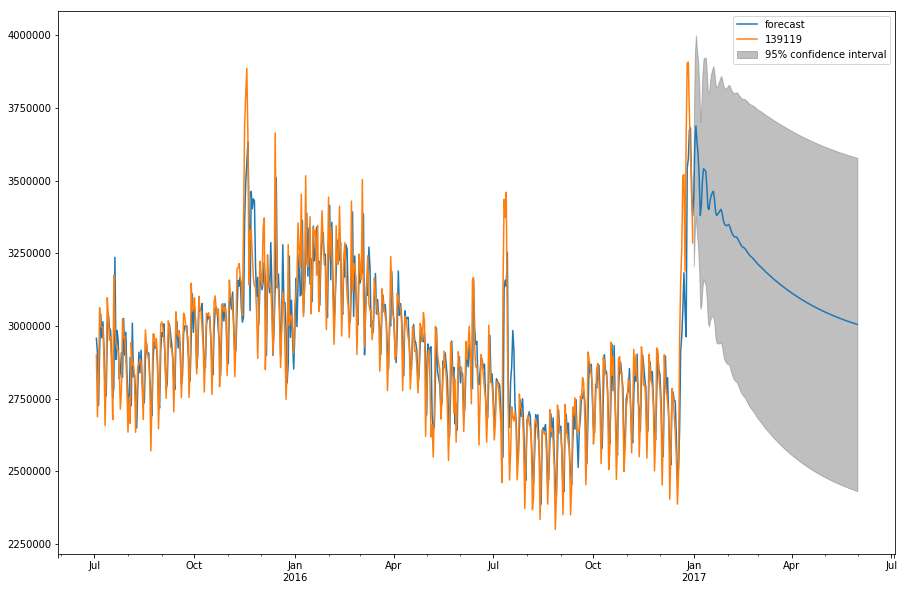

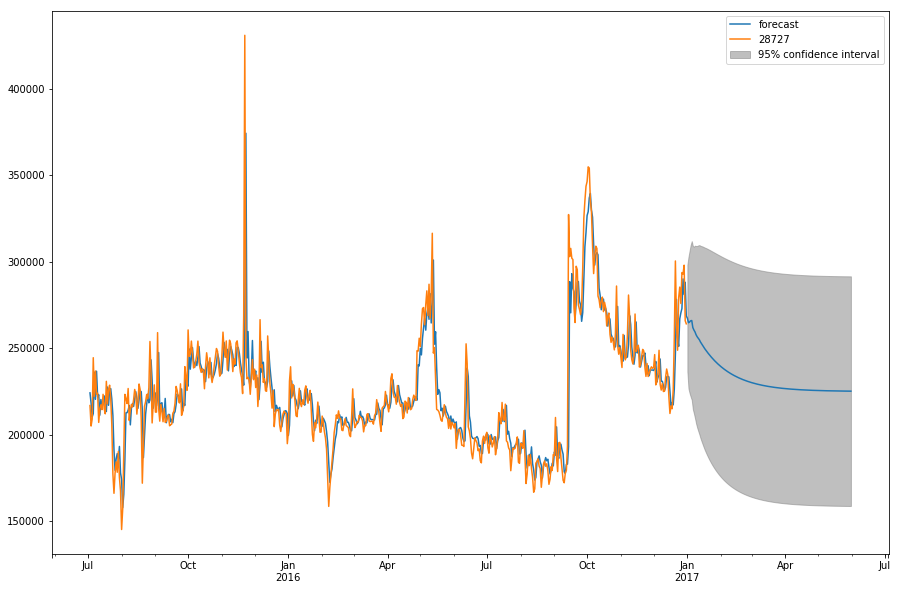

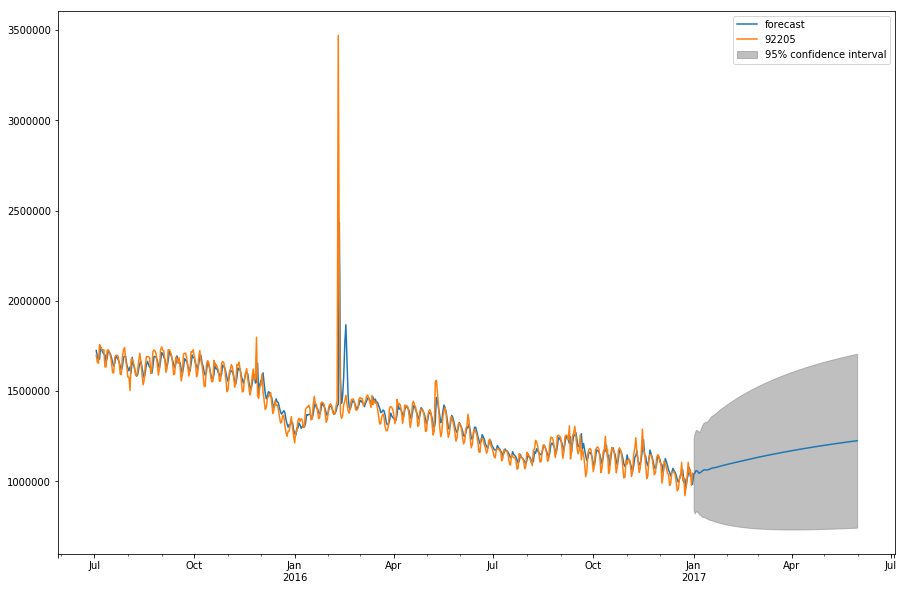

In [25]:
from statsmodels.tsa.arima_model import ARIMA

for i in list_2:
    
    data = pd.DataFrame(train.loc[top_pages[i], :])

#print(data.iloc[1:-1, 0])
    mod = ARMA(data.iloc[1:-1, 0].astype(float), order=(7, 1, 1))
    res = mod.fit()
    
    # Plot the original series and the forecasted series
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    res.plot_predict(start='2015-7-3', end='2017-5-31', ax=ax)
    plt.show()